# **Homework 5 - Sequence-to-sequence**

若有任何問題，歡迎來信至助教信箱 ntu-ml-2021spring-ta@googlegroups.com

### (4/14 Updates) 
1. Link to tutorial [video](https://youtu.be/htG5WpZVQPU).
2. Now defaults to load `"avg_last_5_checkpoint.pt"` to generate prediction.
3. Expected run time on Colab with Tesla T4

|Baseline|Details|Total Time|
|-|:-:|:-:|
|Simple|2m 15s $\times$30 epochs|1hr 8m|
|Medium|4m $\times$30 epochs|2hr|
|Strong|8m $\times$30 epochs (backward)<br>+1hr (back-translation)<br>+15m $\times$30 epochs (forward)|12hr 30m|

# Sequence-to-Sequence 介紹
- 大多數常見的 seq2seq model 為 encoder-decoder model，主要由兩個部分組成，分別是 encoder 和 decoder，而這兩個部可以使用 recurrent neural network (RNN)或 transformer 來實作，主要是用來解決輸入和輸出的長度不一樣的情況
- **Encoder** 是將一連串的輸入，如文字、影片、聲音訊號等，編碼為單個向量，這單個向量可以想像為是整個輸入的抽象表示，包含了整個輸入的資訊
- **Decoder** 是將 encoder 輸出的單個向量逐步解碼，一次輸出一個結果，直到將最後目標輸出被產生出來為止，每次輸出會影響下一次的輸出，一般會在開頭加入 "< BOS >" 來表示開始解碼，會在結尾輸出 "< EOS >" 來表示輸出結束


![seq2seq](https://i.imgur.com/0zeDyuI.png)

# 作業介紹
- 英文翻譯中文
  - 輸入： 一句英文 （e.g.		tom is a student .） 
  - 輸出： 中文翻譯 （e.g. 		湯姆 是 個 學生 。）

- TODO
  - 訓練一個 RNN 模型達到 Seq2seq 翻譯
  - 訓練一個 Transformer 大幅提升效能
  - 實作 Back-translation 大幅提升效能

# 下載和引入需要的函式庫

In [2]:
!nvidia-smi

Wed Apr 28 02:21:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install 'torch>=1.6.0' editdistance matplotlib sacrebleu sacremoses sentencepiece tqdm wandb
!pip install --upgrade jupyter ipywidgets

     |████████████████████████████████| 61kB 7.1MB/s 
     |████████████████████████████████| 901kB 15.0MB/s 
     |████████████████████████████████| 1.2MB 36.3MB/s 
     |████████████████████████████████| 2.1MB 52.0MB/s 
     |████████████████████████████████| 133kB 50.8MB/s 
     |████████████████████████████████| 102kB 13.6MB/s 
     |████████████████████████████████| 163kB 53.9MB/s 
     |████████████████████████████████| 71kB 10.5MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp37-none-any.whl size=6489 sha256=c23399ff80268d8d800873b51d6fbc86011903b47d61abf9fe5bcd602ed027a1
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for pathtools: filename=pathtools-0.1.2-cp37-none-any.whl size=8786 sha256=62370f75cfa75d87e4ec766856c982e2fd4fa3fc5f8cb0549f992915729003c3
  Stored in directory: /root/.cache/pip/wheels/0b/04/79/c3b0c3a0266a3cb4376da31e5bfe8bba0c489246968a68e843
Successfully built subp

In [5]:
!git clone https://github.com/pytorch/fairseq.git
!cd fairseq && git checkout 9a1c497
!pip install --upgrade ./fairseq/

Cloning into 'fairseq'...
remote: Enumerating objects: 27724, done.
remote: Counting objects: 100% (145/145), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 27724 (delta 68), reused 109 (delta 59), pack-reused 27579
Receiving objects: 100% (27724/27724), 11.60 MiB | 17.25 MiB/s, done.
Resolving deltas: 100% (20889/20889), done.
Note: checking out '9a1c497'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by performing another checkout.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -b with the checkout command again. Example:

  git checkout -b <new-branch-name>

HEAD is now at 9a1c4970 Make Hydra logging work with DDP (#1568)
Processing ./fairseq
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... do

In [6]:
import sys
import pdb
import pprint
import logging
import os
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import data
import numpy as np
import tqdm.auto as tqdm
from pathlib import Path
from argparse import Namespace
from fairseq import utils

import matplotlib.pyplot as plt

# 設定種子

In [7]:
seed = 73
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  
np.random.seed(seed)  
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# 資料集介紹

## 英轉繁雙語資料
* [TED2020](#reimers-2020-multilingual-sentence-bert)
    - 原始資料量: 398,066句    
    - 處理後資料: 393,980句
    

## 測試資料
- 資料量: 4,000句
- **中文部分不公開，提供的檔案為假翻譯，全部都是句點。**

# 資料下載

In [8]:
!mkdir -p /content/drive/MyDrive/ML2021-hw5/DATA

In [9]:
!ln -s /content/drive/MyDrive/ML2021-hw5/DATA/ ./DATA

### 安裝megatools (optional)

In [10]:
#!apt-get install megatools

## 下載檔案並解壓縮

In [11]:
data_dir = './DATA/rawdata'
dataset_name = 'ted2020'
urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A"', 
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214987&authkey=AA4qP_azsicwZZM"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted2020.tgz",
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/test.tgz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vEcTCISJ!3Rw0eHTZWPpdHBTbQEqBDikDEdFPr7fI8WxaXK9yZ9U",
#     "https://mega.nz/#!zNcnGIoJ!oPJX9AvVVs11jc0SaK6vxP_lFUNTkEcK2WbxJpvjU5Y",
)
file_names = (
    'ted2020.tgz', # train & dev
    'test.tgz', # test
)
prefix = Path(data_dir).absolute() / dataset_name

prefix.mkdir(parents=True, exist_ok=True)
for u, f in zip(urls, file_names):
    path = prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
!mv {prefix/'raw.en'} {prefix/'train_dev.raw.en'}
!mv {prefix/'raw.zh'} {prefix/'train_dev.raw.zh'}
!mv {prefix/'test.en'} {prefix/'test.raw.en'}
!mv {prefix/'test.zh'} {prefix/'test.raw.zh'}

--2021-04-28 02:23:06--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214989&authkey=AGgQ-DaR8eFSl1A
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://yva8og.dm.files.1drv.com/y4mUGHYBirhRPYyegUsjKrMbwKFj_WDSn924lQY2rggOhWIDM6UnEVFbfPBuXfJebmRNg0dETiM9Uhng2CcujdYH35mwj0LHmYdkH-Bq0hGATghdXjQz2cKWo3N4YOM7Tq-1p68c-Fx4Yjp21Luasv3IO3iLRt5b6F79kuMvcRHe7l2quxNR6lhL_1FnBL8kkjHqBxMZOqQEEXrW7exQthX6g/ted2020.tgz?download&psid=1 [following]
--2021-04-28 02:23:06--  https://yva8og.dm.files.1drv.com/y4mUGHYBirhRPYyegUsjKrMbwKFj_WDSn924lQY2rggOhWIDM6UnEVFbfPBuXfJebmRNg0dETiM9Uhng2CcujdYH35mwj0LHmYdkH-Bq0hGATghdXjQz2cKWo3N4YOM7Tq-1p68c-Fx4Yjp21Luasv3IO3iLRt5b6F79kuMvcRHe7l2quxNR6lhL_1FnBL8kkjHqBxMZOqQEEXrW7exQthX6g/ted2020.tgz?download&psid=1
Resolving yva8og.dm.files.1drv.com (yva8og.dm.files.1drv.com).

## 設定語言

In [12]:
src_lang = 'en'
tgt_lang = 'zh'

data_prefix = f'{prefix}/train_dev.raw'
test_prefix = f'{prefix}/test.raw'

In [13]:
!head {data_prefix+'.'+src_lang} -n 5
!head {data_prefix+'.'+tgt_lang} -n 5

Thank you so much, Chris.
And it's truly a great honor to have the opportunity to come to this stage twice; I'm extremely grateful.
I have been blown away by this conference, and I want to thank all of you for the many nice comments about what I had to say the other night.
And I say that sincerely, partly because  I need that.
Put yourselves in my position.
非常謝謝你，克里斯。能有這個機會第二度踏上這個演講台
真是一大榮幸。我非常感激。
這個研討會給我留下了極為深刻的印象，我想感謝大家 對我之前演講的好評。
我是由衷的想這麼說，有部份原因是因為 —— 我真的有需要!
請你們設身處地為我想一想！


## 檔案前處理

In [14]:
import re

def strQ2B(ustring):
    """把字串全形轉半形"""
    # 參考來源:https://ithelp.ithome.com.tw/articles/10233122
    ss = []
    for s in ustring:
        rstring = ""
        for uchar in s:
            inside_code = ord(uchar)
            if inside_code == 12288:  # 全形空格直接轉換
                inside_code = 32
            elif (inside_code >= 65281 and inside_code <= 65374):  # 全形字元（除空格）根據關係轉化
                inside_code -= 65248
            rstring += chr(inside_code)
        ss.append(rstring)
    return ''.join(ss)
                
def clean_s(s, lang):
    if lang == 'en':
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace('-', '') # remove '-'
        s = re.sub('([.,;!?()\"])', r' \1 ', s) # keep punctuation
    elif lang == 'zh':
        s = strQ2B(s) # Q2B
        s = re.sub(r"\([^()]*\)", "", s) # remove ([text])
        s = s.replace(' ', '')
        s = s.replace('—', '')
        s = s.replace('“', '"')
        s = s.replace('”', '"')
        s = s.replace('_', '')
        s = re.sub('([。,;!?()\"~「」])', r' \1 ', s) # keep punctuation
    s = ' '.join(s.strip().split())
    return s

def len_s(s, lang):
    if lang == 'zh':
        return len(s)
    return len(s.split())

def clean_corpus(prefix, l1, l2, ratio=9, max_len=1000, min_len=1):
    if Path(f'{prefix}.clean.{l1}').exists() and Path(f'{prefix}.clean.{l2}').exists():
        print(f'{prefix}.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{prefix}.{l1}', 'r') as l1_in_f:
        with open(f'{prefix}.{l2}', 'r') as l2_in_f:
            with open(f'{prefix}.clean.{l1}', 'w') as l1_out_f:
                with open(f'{prefix}.clean.{l2}', 'w') as l2_out_f:
                    for s1 in l1_in_f:
                        s1 = s1.strip()
                        s2 = l2_in_f.readline().strip()
                        s1 = clean_s(s1, l1)
                        s2 = clean_s(s2, l2)
                        s1_len = len_s(s1, l1)
                        s2_len = len_s(s2, l2)
                        if min_len > 0: # remove short sentence
                            if s1_len < min_len or s2_len < min_len:
                                continue
                        if max_len > 0: # remove long sentence
                            if s1_len > max_len or s2_len > max_len:
                                continue
                        if ratio > 0: # remove by ratio of length
                            if s1_len/s2_len > ratio or s2_len/s1_len > ratio:
                                continue
                        print(s1, file=l1_out_f)
                        print(s2, file=l2_out_f)

In [15]:
clean_corpus(data_prefix, src_lang, tgt_lang)
clean_corpus(test_prefix, src_lang, tgt_lang, ratio=-1, min_len=-1, max_len=-1)

In [16]:
!head {data_prefix+'.clean.'+src_lang} -n 5
!head {data_prefix+'.clean.'+tgt_lang} -n 5

Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .
非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !


## 切出 train/valid set

In [17]:
valid_ratio = 0.01 # 3000~4000句就夠了
train_ratio = 1 - valid_ratio

In [18]:
if (prefix/f'train.clean.{src_lang}').exists() \
and (prefix/f'train.clean.{tgt_lang}').exists() \
and (prefix/f'valid.clean.{src_lang}').exists() \
and (prefix/f'valid.clean.{tgt_lang}').exists():
    print(f'train/valid splits exists. skipping split.')
else:
    line_num = sum(1 for line in open(f'{data_prefix}.clean.{src_lang}'))
    labels = list(range(line_num))
    random.shuffle(labels)
    for lang in [src_lang, tgt_lang]:
        train_f = open(os.path.join(data_dir, dataset_name, f'train.clean.{lang}'), 'w')
        valid_f = open(os.path.join(data_dir, dataset_name, f'valid.clean.{lang}'), 'w')
        count = 0
        for line in open(f'{data_prefix}.clean.{lang}', 'r'):
            if labels[count]/line_num < train_ratio:
                train_f.write(line)
            else:
                valid_f.write(line)
            count += 1
        train_f.close()
        valid_f.close()

## Subword Units 
翻譯存在的一大問題是未登錄詞(out of vocabulary)，可以使用 subword units 作為斷詞單位來解決。
- 使用 [sentencepiece](#kudo-richardson-2018-sentencepiece) 套件
- 用 unigram 或 byte-pair encoding (BPE)

In [19]:
import sentencepiece as spm
vocab_size = 8000
if (prefix/f'spm{vocab_size}.model').exists():
    print(f'{prefix}/spm{vocab_size}.model exists. skipping spm_train.')
else:
    spm.SentencePieceTrainer.train(
        input=','.join([f'{prefix}/train.clean.{src_lang}',
                        f'{prefix}/valid.clean.{src_lang}',
                        f'{prefix}/train.clean.{tgt_lang}',
                        f'{prefix}/valid.clean.{tgt_lang}']),
        model_prefix=prefix/f'spm{vocab_size}',
        vocab_size=vocab_size,
        character_coverage=1,
        model_type='unigram', # 'bpe' 也可
        input_sentence_size=1e6,
        shuffle_input_sentence=True,
        normalization_rule_name='nmt_nfkc_cf',
    )

In [20]:
spm_model = spm.SentencePieceProcessor(model_file=str(prefix/f'spm{vocab_size}.model'))
in_tag = {
    'train': 'train.clean',
    'valid': 'valid.clean',
    'test': 'test.raw.clean',
}
for split in ['train', 'valid', 'test']:
    for lang in [src_lang, tgt_lang]:
        out_path = prefix/f'{split}.{lang}'
        if out_path.exists():
            print(f"{out_path} exists. skipping spm_encode.")
        else:
            with open(prefix/f'{split}.{lang}', 'w') as out_f:
                with open(prefix/f'{in_tag[split]}.{lang}', 'r') as in_f:
                    for line in in_f:
                        line = line.strip()
                        tok = spm_model.encode(line, out_type=str)
                        print(' '.join(tok), file=out_f)

In [21]:
!head {data_dir+'/'+dataset_name+'/train.'+src_lang} -n 5
!head {data_dir+'/'+dataset_name+'/train.'+tgt_lang} -n 5

▁thank ▁you ▁so ▁much ▁, ▁chris ▁.
▁and ▁it ' s ▁ t ru ly ▁a ▁great ▁ho n or ▁to ▁have ▁the ▁ op port un ity ▁to ▁come ▁to ▁this ▁st age ▁ t wi ce ▁ ; ▁i ' m ▁ex t re me ly ▁gr ate ful ▁.
▁i ▁have ▁been ▁ bl own ▁away ▁by ▁this ▁con fer ence ▁, ▁and ▁i ▁want ▁to ▁thank ▁all ▁of ▁you ▁for ▁the ▁many ▁ ni ce ▁ com ment s ▁about ▁what ▁i ▁had ▁to ▁say ▁the ▁other ▁night ▁.
▁and ▁i ▁say ▁that ▁since re ly ▁, ▁part ly ▁because ▁i ▁need ▁that ▁.
▁put ▁your s el ve s ▁in ▁my ▁po s ition ▁.
▁ 非常 謝 謝 你 ▁, ▁ 克 里 斯 ▁ 。 ▁ 能 有 這個 機會 第二 度 踏 上 這個 演講 台
▁ 真 是 一 大 榮 幸 ▁ 。 ▁我 非常 感 激 ▁ 。
▁這個 研 討 會 給我 留 下 了 極 為 深 刻 的 印 象 ▁, ▁我想 感 謝 大家 對 我 之前 演講 的 好 評 ▁ 。
▁我 是由 衷 的 想 這麼 說 ▁, ▁有 部份 原因 是因為 我 真的 有 需要 ▁ !
▁ 請 你們 設 身 處 地 為 我想 一 想 ▁ !


## 用 fairseq 將資料轉為 binary

In [22]:
binpath = Path('./DATA/data-bin', dataset_name)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess \
        --source-lang {src_lang}\
        --target-lang {tgt_lang}\
        --trainpref {prefix/'train'}\
        --validpref {prefix/'valid'}\
        --testpref {prefix/'test'}\
        --destdir {binpath}\
        --joined-dictionary\
        --workers 2

2021-04-28 02:27:06 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/ted2020', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=True, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='en', srcdict=None, suppress_crashes=False, target_lang='zh', task='translation', tensorboard_logdir=None, testpref='/content/DATA/rawdata/ted2020/test', tgtdict=None, threshold_loss_scale=None, thresholdsrc=0, t

# 實驗的參數設定表

In [23]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020",
    savedir = "/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back",
    source_lang = "zh",
    target_lang = "en",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=8192,
    accum_steps=2,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=30,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=5,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

# Logging
- logging 套件紀錄一般訊息
- wandb 紀錄續練過程 loss, bleu, model weight 等等

In [24]:
logging.basicConfig(
    format="%(asctime)s | %(levelname)s | %(name)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S",
    level="INFO", # "DEBUG" "WARNING" "ERROR"
    stream=sys.stdout,
)
proj = "hw5.seq2seq"
logger = logging.getLogger(proj)
if config.use_wandb:
    import wandb
    wandb.init(project=proj, name=Path(config.savedir).stem, config=config)

# CUDA環境

In [25]:
cuda_env = utils.CudaEnvironment()
utils.CudaEnvironment.pretty_print_cuda_env_list([cuda_env])
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

2021-04-28 02:29:00 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************
2021-04-28 02:29:00 | INFO | fairseq.utils | rank   0: capabilities =  7.0  ; total memory = 15.782 GB ; name = Tesla V100-SXM2-16GB                    
2021-04-28 02:29:00 | INFO | fairseq.utils | ***********************CUDA enviroments for all 1 workers***********************


# 讀取資料集

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [26]:
from fairseq.tasks.translation import TranslationConfig, TranslationTask

## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-28 02:29:00 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types
2021-04-28 02:29:00 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types


In [27]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-28 02:29:00 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-28 02:29:00 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.zh
2021-04-28 02:29:00 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020/train.en-zh.en
2021-04-28 02:29:00 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 train zh-en 390041 examples
2021-04-28 02:29:00 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.zh
2021-04-28 02:29:00 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020/valid.en-zh.en
2021-04-28 02:29:00 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 valid zh-en 3939 examples


In [28]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2]),
 'target': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2])}
'Source: 這實在就是我所做的--光學操控思想'
"Target: that's exactly what i do optical mind control ."


## Dataset Iterator

* 將每個 batch 控制在 N 個 token 讓 GPU 記憶體更有效被利用
* 讓 training set 每個 epoch 有不同 shuffling
* 濾掉長度太長的句子
* 將每個 batch 內的句子 pad 成一樣長，好讓 GPU 平行運算
* 加上 eos 並 shift 一格
    - teacher forcing: 為了訓練模型根據prefix生成下個字，decoder的輸入會是輸出目標序列往右shift一格。
    - 一般是會在輸入開頭加個bos token (如下圖)
![seq2seq](https://i.imgur.com/0zeDyuI.png)
    - fairseq 則是直接把 eos 挪到 beginning，訓練起來效果其實差不多。例如: 
    ```
    # 輸出目標 (target) 和 Decoder輸入 (prev_output_tokens): 
                   eos = 2
                target = 419,  711,  238,  888,  792,   60,  968,    8,    2
    prev_output_tokens = 2,  419,  711,  238,  888,  792,   60,  968,    8
    ```


In [29]:
def load_data_iterator(task, split, epoch=1, max_tokens=4000, num_workers=1, cached=True):
    batch_iterator = task.get_batch_iterator(
        dataset=task.dataset(split),
        max_tokens=max_tokens,
        max_sentences=None,
        max_positions=utils.resolve_max_positions(
            task.max_positions(),
            max_tokens,
        ),
        ignore_invalid_inputs=True,
        seed=seed,
        num_workers=num_workers,
        epoch=epoch,
        disable_iterator_cache=not cached,
        # Set this to False to speed up. However, if set to False, changing max_tokens beyond 
        # first call of this method has no effect. 
    )
    return batch_iterator

demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-28 02:29:00 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[3525, 1062, 527, 2861, 2415, 1633, 1624, 2626, 210, 880]


{'id': tensor([3517]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,
            188,    4,   33,    4,   32,    1,    1,    1,    1,    1,    1,    1]]),
  'src_lengths': tensor([13]),
  'src_tokens': tensor([[   1,    1,    1,    4, 1259, 2926,  157, 3552, 1591,  137,  162, 1173,
            434,    4,   33,    2]])},
 'nsentences': 1,
 'ntokens': 17,
 'target': tensor([[   4,   32,   63,    8,  796, 1556, 1562,   13,  691,  116,  124,  188,
             4,   33,    4,   32,    2,    1,    1,    1,    1,    1,    1,    1]])}

* 每個 batch 是一個字典，key 是字串，value 是 Tensor，內容說明如下
```python
batch = {
    "id": id, # 每個 example 的 id
    "nsentences": len(samples), # batch size 句子數
    "ntokens": ntokens, # batch size 字數
    "net_input": {
        "src_tokens": src_tokens, # 來源語言的序列
        "src_lengths": src_lengths, # 每句話沒有 pad 過的長度
        "prev_output_tokens": prev_output_tokens, # 上面提到右 shift 一格後的目標序列
    },
    "target": target, # 目標序列
}
```

# 定義模型架構
* 我們一樣繼承 fairseq 的 encoder, decoder 和 model, 這樣測試階段才能直接用他寫好的 beam search 函式

In [30]:
from fairseq.models import (
    FairseqEncoder, 
    FairseqIncrementalDecoder,
    FairseqEncoderDecoderModel
)

## Seq2Seq
- 由 **Encoder** 和 **Decoder** 組成
- 接收輸入並傳給 **Encoder** 
- 將 **Encoder** 的輸出傳給 **Decoder**
- **Decoder** 根據前幾個 timestep 的輸出和 **Encoder** 輸出進行解碼  
- 當解碼完成後，將 **Decoder** 的輸出傳回 

In [31]:
class Seq2Seq(FairseqEncoderDecoderModel):
    def __init__(self, args, encoder, decoder):
        super().__init__(encoder, decoder)
        self.args = args
    
    def forward(
        self,
        src_tokens,
        src_lengths,
        prev_output_tokens,
        return_all_hiddens: bool = True,
    ):
        """
        Run the forward pass for an encoder-decoder model.
        """
        encoder_out = self.encoder(
            src_tokens, src_lengths=src_lengths, return_all_hiddens=return_all_hiddens
        )
        logits, extra = self.decoder(
            prev_output_tokens,
            encoder_out=encoder_out,
            src_lengths=src_lengths,
            return_all_hiddens=return_all_hiddens,
        )
        return logits, extra

# 模型初始化

In [32]:
# # HINT: transformer 架構
from fairseq.models.transformer import (
     TransformerEncoder, 
     TransformerDecoder,
)

def build_model(args, task):
    """ 按照參數設定建置模型 """
    src_dict, tgt_dict = task.source_dictionary, task.target_dictionary

    # 詞嵌入
    encoder_embed_tokens = nn.Embedding(len(src_dict), args.encoder_embed_dim, src_dict.pad())
    decoder_embed_tokens = nn.Embedding(len(tgt_dict), args.decoder_embed_dim, tgt_dict.pad())
    
    # 編碼器與解碼器
    # TODO: 替換成 TransformerEncoder 和 TransformerDecoder
    encoder = TransformerEncoder(args, src_dict, encoder_embed_tokens)
    decoder = TransformerDecoder(args, tgt_dict, decoder_embed_tokens)
    
    # 序列到序列模型
    model = Seq2Seq(args, encoder, decoder)
    
    # 序列到序列模型的初始化很重要 需要特別處理
    def init_params(module):
        from fairseq.modules import MultiheadAttention
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=0.02)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        if isinstance(module, MultiheadAttention):
            module.q_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.k_proj.weight.data.normal_(mean=0.0, std=0.02)
            module.v_proj.weight.data.normal_(mean=0.0, std=0.02)
        if isinstance(module, nn.RNNBase):
            for name, param in module.named_parameters():
                if "weight" in name or "bias" in name:
                    param.data.uniform_(-0.1, 0.1)
            
    # 初始化模型
    model.apply(init_params)
    return model

## 設定模型相關參數
參考參數

|model|embedding dim|encoder ffn|encoder layers|decoder ffn|decoder layers|
|-|-|-|-|-|-|
|RNN|256|512|1|1024|1|
|Transformer|256|1024|4|1024|4|

Strong baseline 用的參數可以參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 transformer-base

In [33]:
# transformer-base
arch_args = Namespace(
    encoder_embed_dim=512,
    encoder_ffn_embed_dim=2048,
    encoder_layers=6,
    decoder_embed_dim=512,
    decoder_ffn_embed_dim=2048,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.1,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=8
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=8
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [34]:
if config.use_wandb:
    wandb.config.update(vars(arch_args))

In [35]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-28 02:29:02 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 512, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=512, out_features=512, bias=True)
          (v_proj): Linear(in_features=512, out_features=512, bias=True)
          (q_proj): Linear(in_features=512, out_features=512, bias=True)
          (out_proj): Linear(in_features=512, out_features=512, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=512, out_features=2048, bias=True)
        (fc2): Linear(in_features=2048, out_features=512, bia

# Optimization 最佳化

## Loss: Label Smoothing Regularization
* 讓模型學習輸出較不集中的分佈，防止模型過度自信
* 有時候Ground Truth並非唯一答案，所以在算loss時，我們會保留一部份機率給正確答案以外的label
* 可以有效防止過度擬合

code [source](https://fairseq.readthedocs.io/en/latest/_modules/fairseq/criterions/label_smoothed_cross_entropy.html)

In [36]:
class LabelSmoothedCrossEntropyCriterion(nn.Module):
    def __init__(self, smoothing, ignore_index=None, reduce=True):
        super().__init__()
        self.smoothing = smoothing
        self.ignore_index = ignore_index
        self.reduce = reduce
    
    def forward(self, lprobs, target):
        if target.dim() == lprobs.dim() - 1:
            target = target.unsqueeze(-1)
        # nll: Negative log likelihood，當目標是one-hot時的cross-entropy loss. 以下同 F.nll_loss
        nll_loss = -lprobs.gather(dim=-1, index=target)
        # 將一部分正確答案的機率分配給其他label 所以當計算cross-entropy時等於把所有label的log prob加起來
        smooth_loss = -lprobs.sum(dim=-1, keepdim=True)
        if self.ignore_index is not None:
            pad_mask = target.eq(self.ignore_index)
            nll_loss.masked_fill_(pad_mask, 0.0)
            smooth_loss.masked_fill_(pad_mask, 0.0)
        else:
            nll_loss = nll_loss.squeeze(-1)
            smooth_loss = smooth_loss.squeeze(-1)
        if self.reduce:
            nll_loss = nll_loss.sum()
            smooth_loss = smooth_loss.sum()
        # 計算cross-entropy時 加入分配給其他label的loss
        eps_i = self.smoothing / lprobs.size(-1)
        loss = (1.0 - self.smoothing) * nll_loss + eps_i * smooth_loss
        return loss

# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

## Optimizer: Adam + lr scheduling
Inverse square root 排程對於訓練 Transformer 時的穩定性很重要，後來也用在 RNN 上。
根據底下公式來更新 learning rate，前期線性增長，後期根據更新步數方根的倒數來遞減。
$$lrate = d_{\text{model}}^{-0.5}\cdot\min({step\_num}^{-0.5},{step\_num}\cdot{warmup\_steps}^{-1.5})$$
code [source](https://nlp.seas.harvard.edu/2018/04/03/attention.html)

In [37]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
    
    @property
    def param_groups(self):
        return self.optimizer.param_groups
        
    def multiply_grads(self, c):
        """Multiplies grads by a constant *c*."""                
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is not None:
                    p.grad.data.mul_(c)
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        return 0 if not step else self.factor * \
            (self.model_size ** (-0.5) *
            min(step ** (-0.5), step * self.warmup ** (-1.5)))

## 排程視覺化

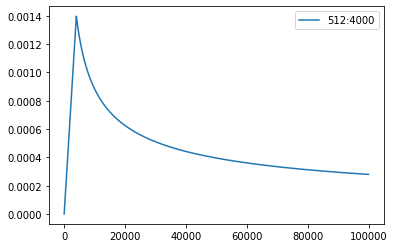

In [38]:
optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))
plt.plot(np.arange(1, 100000), [optimizer.rate(i) for i in range(1, 100000)])
plt.legend([f"{optimizer.model_size}:{optimizer.warmup}"])
None

# 訓練步驟

## Training 訓練

In [39]:
from fairseq.data import iterators
from torch.cuda.amp import GradScaler, autocast

def train_one_epoch(epoch_itr, model, task, criterion, optimizer, accum_steps=1):
    itr = epoch_itr.next_epoch_itr(shuffle=True)
    itr = iterators.GroupedIterator(itr, accum_steps) # 梯度累積: 每 accum_steps 個 sample 更新一次
    
    stats = {"loss": []}
    scaler = GradScaler() # 混和精度訓練 automatic mixed precision (amp) 
    
    model.train()
    progress = tqdm.tqdm(itr, desc=f"train epoch {epoch_itr.epoch}", leave=False)
    for samples in progress:
        model.zero_grad()
        accum_loss = 0
        sample_size = 0
        # 梯度累積: 每 accum_steps 個 sample 更新一次
        for i, sample in enumerate(samples):
            if i == 1:
                # emptying the CUDA cache after the first step can reduce the chance of OOM
                torch.cuda.empty_cache()

            sample = utils.move_to_cuda(sample, device=device)
            target = sample["target"]
            sample_size_i = sample["ntokens"]
            sample_size += sample_size_i
            
            # 混和精度訓練 
            with autocast():
                net_output = model.forward(**sample["net_input"])
                lprobs = F.log_softmax(net_output[0], -1)            
                loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1))
                
                # logging
                accum_loss += loss.item()
                # back-prop
                scaler.scale(loss).backward()                
        
        scaler.unscale_(optimizer)
        optimizer.multiply_grads(1 / (sample_size or 1.0)) # (sample_size or 1.0) handles the case of a zero gradient
        gnorm = nn.utils.clip_grad_norm_(model.parameters(), config.clip_norm) # 梯度裁剪 防止梯度爆炸
        
        scaler.step(optimizer)
        scaler.update()
        
        # logging
        loss_print = accum_loss/sample_size
        stats["loss"].append(loss_print)
        progress.set_postfix(loss=loss_print)
        if config.use_wandb:
            wandb.log({
                "train/loss": loss_print,
                "train/grad_norm": gnorm.item(),
                "train/lr": optimizer.rate(),
                "train/sample_size": sample_size,
            })
        
    loss_print = np.mean(stats["loss"])
    logger.info(f"training loss: {loss_print:.4f}")
    return stats

## Validation & Inference 檢驗和推論
為防止訓練發生過度擬合，每過一段時間要做一次檢測，計算模型在未看過的資料上的表現。
- 過程基本上和training一樣，另外加上 inference
- 檢驗完畢可順便儲存模型參數

單看 validation loss，我們很難知道模型真實的效能
- 直接用當前模型去生成翻譯結果 (hypothesis)，再和正確答案 (reference) 計算 BLEU score
- 也可用肉眼看翻譯結果的好壞
- 我們用 fairseq 寫好的 sequence generator 來進行 beam search 生成翻譯結果

In [40]:
# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)

def decode(toks, dictionary):
    # 從 Tensor 轉成人看得懂的句子
    s = dictionary.string(
        toks.int().cpu(),
        config.post_process,
    )
    return s if s else "<unk>"

def inference_step(sample, model):
    gen_out = sequence_generator.generate([model], sample)
    srcs = []
    hyps = []
    refs = []
    for i in range(len(gen_out)):
        # 對於每個 sample, 收集輸入，輸出和參考答案，稍後計算 BLEU
        srcs.append(decode(
            utils.strip_pad(sample["net_input"]["src_tokens"][i], task.source_dictionary.pad()), 
            task.source_dictionary,
        ))
        hyps.append(decode(
            gen_out[i][0]["tokens"], # 0 代表取出 beam 內分數第一的輸出結果
            task.target_dictionary,
        ))
        refs.append(decode(
            utils.strip_pad(sample["target"][i], task.target_dictionary.pad()), 
            task.target_dictionary,
        ))
    return srcs, hyps, refs

In [41]:
import shutil
import sacrebleu

def validate(model, task, criterion, log_to_wandb=True):
    logger.info('begin validation')
    itr = load_data_iterator(task, "valid", 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    stats = {"loss":[], "bleu": 0, "srcs":[], "hyps":[], "refs":[]}
    srcs = []
    hyps = []
    refs = []
    
    model.eval()
    progress = tqdm.tqdm(itr, desc=f"validation", leave=False)
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)
            net_output = model.forward(**sample["net_input"])

            lprobs = F.log_softmax(net_output[0], -1)
            target = sample["target"]
            sample_size = sample["ntokens"]
            loss = criterion(lprobs.view(-1, lprobs.size(-1)), target.view(-1)) / sample_size
            progress.set_postfix(valid_loss=loss.item())
            stats["loss"].append(loss)
            
            # 進行推論
            s, h, r = inference_step(sample, model)
            srcs.extend(s)
            hyps.extend(h)
            refs.extend(r)
            
    tok = 'zh' if task.cfg.target_lang == 'zh' else '13a'
    stats["loss"] = torch.stack(stats["loss"]).mean().item()
    stats["bleu"] = sacrebleu.corpus_bleu(hyps, [refs], tokenize=tok) # 計算BLEU score
    stats["srcs"] = srcs
    stats["hyps"] = hyps
    stats["refs"] = refs
    
    if config.use_wandb and log_to_wandb:
        wandb.log({
            "valid/loss": stats["loss"],
            "valid/bleu": stats["bleu"].score,
        }, commit=False)
    
    showid = np.random.randint(len(hyps))
    logger.info("example source: " + srcs[showid])
    logger.info("example hypothesis: " + hyps[showid])
    logger.info("example reference: " + refs[showid])
    
    # show bleu results
    logger.info(f"validation loss:\t{stats['loss']:.4f}")
    logger.info(stats["bleu"].format())
    return stats

# 儲存及載入模型參數

In [42]:
def validate_and_save(model, task, criterion, optimizer, epoch, save=True):   
    stats = validate(model, task, criterion)
    bleu = stats['bleu']
    loss = stats['loss']
    if save:
        # save epoch checkpoints
        savedir = Path(config.savedir).absolute()
        savedir.mkdir(parents=True, exist_ok=True)
        
        check = {
            "model": model.state_dict(),
            "stats": {"bleu": bleu.score, "loss": loss},
            "optim": {"step": optimizer._step}
        }
        torch.save(check, savedir/f"checkpoint{epoch}.pt")
        shutil.copy(savedir/f"checkpoint{epoch}.pt", savedir/f"checkpoint_last.pt")
        logger.info(f"saved epoch checkpoint: {savedir}/checkpoint{epoch}.pt")
    
        # save epoch samples
        with open(savedir/f"samples{epoch}.{config.source_lang}-{config.target_lang}.txt", "w") as f:
            for s, h in zip(stats["srcs"], stats["hyps"]):
                f.write(f"{s}\t{h}\n")

        # get best valid bleu    
        if getattr(validate_and_save, "best_bleu", 0) < bleu.score:
            validate_and_save.best_bleu = bleu.score
            torch.save(check, savedir/f"checkpoint_best.pt")
            
        del_file = savedir / f"checkpoint{epoch - config.keep_last_epochs}.pt"
        if del_file.exists():
            del_file.unlink()
    
    return stats

def try_load_checkpoint(model, optimizer=None, name=None):
    name = name if name else "checkpoint_last.pt"
    checkpath = Path(config.savedir)/name
    if checkpath.exists():
        check = torch.load(checkpath)
        model.load_state_dict(check["model"])
        stats = check["stats"]
        step = "unknown"
        if optimizer != None:
            optimizer._step = step = check["optim"]["step"]
        logger.info(f"loaded checkpoint {checkpath}: step={step} loss={stats['loss']} bleu={stats['bleu']}")
    else:
        logger.info(f"no checkpoints found at {checkpath}!")

# 主程式
## 訓練迴圈

In [43]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [44]:
!nvidia-smi

Wed Apr 28 02:29:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    38W / 300W |   1531MiB / 16160MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [45]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-28 02:29:10 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-28 02:29:10 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-28 02:29:10 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-28 02:29:10 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-28 02:29:10 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-28 02:29:10 | INFO | hw5.seq2seq | num. model params: 52,332,544 (num. trained: 52,332,544)
2021-04-28 02:29:10 | INFO | hw5.seq2seq | max tokens per batch = 8192, accumulate steps = 2


In [46]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-28 02:29:10 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-28 02:29:10 | INFO | hw5.seq2seq | no checkpoints found at /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint_last.pt!


2021-04-28 02:34:19 | INFO | hw5.seq2seq | training loss: 5.5430
2021-04-28 02:34:19 | INFO | hw5.seq2seq | begin validation


2021-04-28 02:34:53 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 02:34:53 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 02:34:53 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 02:34:54 | INFO | hw5.seq2seq | example source: 而且我們也知道 , 我們在失去二氧化碳 。
2021-04-28 02:34:54 | INFO | hw5.seq2seq | example hypothesis: and we also know , we know , we know , we've got oxide oxye .
2021-04-28 02:34:54 | INFO | hw5.seq2seq | example reference: and we knew that we were losing co2 .
2021-04-28 02:34:54 | INFO | hw5.seq2seq | validation loss:	4.2347
2021-04-28 02:34:54 | INFO | hw5.seq2seq | BLEU = 3.21 25.2/5.7/1.6/0.5 (BP = 1.000 ratio = 1.156 hyp_len = 89060 ref_len = 77050)
2021-04-28 02:34:56 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-ba

2021-04-28 02:40:04 | INFO | hw5.seq2seq | training loss: 3.7996
2021-04-28 02:40:04 | INFO | hw5.seq2seq | begin validation


2021-04-28 02:40:33 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 02:40:33 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 02:40:33 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 02:40:35 | INFO | hw5.seq2seq | example source: 不過就是意識嘛 。 」
2021-04-28 02:40:35 | INFO | hw5.seq2seq | example hypothesis: but it's conscious . "
2021-04-28 02:40:35 | INFO | hw5.seq2seq | example reference: well , consciousness . "
2021-04-28 02:40:35 | INFO | hw5.seq2seq | validation loss:	3.3685
2021-04-28 02:40:35 | INFO | hw5.seq2seq | BLEU = 9.09 49.5/18.5/8.3/3.9 (BP = 0.691 ratio = 0.730 hyp_len = 56281 ref_len = 77050)
2021-04-28 02:40:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint2.pt
2021-04-28 02:40:37 | INFO | hw5.seq2seq | 

2021-04-28 02:45:46 | INFO | hw5.seq2seq | training loss: 3.2392
2021-04-28 02:45:46 | INFO | hw5.seq2seq | begin validation


2021-04-28 02:46:17 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 02:46:17 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 02:46:17 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 02:46:19 | INFO | hw5.seq2seq | example source: 你以為自己有幾斤幾兩 ?
2021-04-28 02:46:19 | INFO | hw5.seq2seq | example hypothesis: do you think there's two kilos of yourself ?
2021-04-28 02:46:19 | INFO | hw5.seq2seq | example reference: who do you think you are ?
2021-04-28 02:46:19 | INFO | hw5.seq2seq | validation loss:	3.0363
2021-04-28 02:46:19 | INFO | hw5.seq2seq | BLEU = 12.84 48.7/20.0/9.6/4.8 (BP = 0.882 ratio = 0.888 hyp_len = 68447 ref_len = 77050)
2021-04-28 02:46:20 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint3.pt
2021-04-28 02:46:

2021-04-28 02:51:31 | INFO | hw5.seq2seq | training loss: 3.0071
2021-04-28 02:51:31 | INFO | hw5.seq2seq | begin validation


2021-04-28 02:52:02 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 02:52:02 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 02:52:02 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 02:52:03 | INFO | hw5.seq2seq | example source: 在現代科學的協助下 , 棉可能很快就會變得比過去更軟、更堅固 , 且更有彈性 , 因為研究者正在根據營養物、氣候條件 , 以及遺傳學 , 探究如何將棉的生成做到最佳化 。
2021-04-28 02:52:03 | INFO | hw5.seq2seq | example hypothesis: in modern science , the cotton may be so softer and flexible , because the researchers are based on nutrition , climate conditions , and genetics , and genetics , explore how to optimize cotton .
2021-04-28 02:52:03 | INFO | hw5.seq2seq | example reference: and with the help of modern science , cotton might soon be softer , stronger , and more resilient than ever as researchers investigate how to optimize its growth bas

2021-04-28 02:57:14 | INFO | hw5.seq2seq | training loss: 2.8856
2021-04-28 02:57:14 | INFO | hw5.seq2seq | begin validation


2021-04-28 02:57:46 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 02:57:46 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 02:57:46 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 02:57:47 | INFO | hw5.seq2seq | example source: 隨著油價上漲 , 能源專利也愈多 。
2021-04-28 02:57:47 | INFO | hw5.seq2seq | example hypothesis: as oil prices are rising , the more energy patents are .
2021-04-28 02:57:47 | INFO | hw5.seq2seq | example reference: as oil prices go up , energy patents go up .
2021-04-28 02:57:47 | INFO | hw5.seq2seq | validation loss:	2.8581
2021-04-28 02:57:47 | INFO | hw5.seq2seq | BLEU = 15.45 47.5/20.8/10.6/5.6 (BP = 0.995 ratio = 0.995 hyp_len = 76635 ref_len = 77050)
2021-04-28 02:57:49 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-

2021-04-28 03:02:56 | INFO | hw5.seq2seq | training loss: 2.7756
2021-04-28 03:02:56 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:03:27 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:03:27 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:03:27 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:03:29 | INFO | hw5.seq2seq | example source: 讓我們多想想資料
2021-04-28 03:03:29 | INFO | hw5.seq2seq | example hypothesis: let's think more about the data .
2021-04-28 03:03:29 | INFO | hw5.seq2seq | example reference: let's think about data for a bit .
2021-04-28 03:03:29 | INFO | hw5.seq2seq | validation loss:	2.7261
2021-04-28 03:03:29 | INFO | hw5.seq2seq | BLEU = 17.60 53.5/25.0/13.4/7.4 (BP = 0.921 ratio = 0.924 hyp_len = 71223 ref_len = 77050)
2021-04-28 03:03:30 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint6.pt
2021-04-28 03:03:31 | I

2021-04-28 03:08:38 | INFO | hw5.seq2seq | training loss: 2.6572
2021-04-28 03:08:38 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:09:09 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:09:09 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:09:09 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:09:10 | INFO | hw5.seq2seq | example source: 所以我們也當如此
2021-04-28 03:09:10 | INFO | hw5.seq2seq | example hypothesis: so we do .
2021-04-28 03:09:10 | INFO | hw5.seq2seq | example reference: and so it should be with us .
2021-04-28 03:09:10 | INFO | hw5.seq2seq | validation loss:	2.6661
2021-04-28 03:09:10 | INFO | hw5.seq2seq | BLEU = 18.02 56.7/27.2/14.9/8.4 (BP = 0.862 ratio = 0.870 hyp_len = 67070 ref_len = 77050)
2021-04-28 03:09:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint7.pt
2021-04-28 03:09:13 | INFO | hw5.seq2seq | end of e

2021-04-28 03:14:21 | INFO | hw5.seq2seq | training loss: 2.5681
2021-04-28 03:14:21 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:14:52 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:14:52 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:14:52 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:14:54 | INFO | hw5.seq2seq | example source: 噢 , 好 , 好了 ! 你們都別再打了 !
2021-04-28 03:14:54 | INFO | hw5.seq2seq | example hypothesis: oh , okay , so you don't hit anymore !
2021-04-28 03:14:54 | INFO | hw5.seq2seq | example reference: oh great ! yeah . yeah you can all stop calling now !
2021-04-28 03:14:54 | INFO | hw5.seq2seq | validation loss:	2.6068
2021-04-28 03:14:54 | INFO | hw5.seq2seq | BLEU = 18.94 55.7/27.0/14.9/8.5 (BP = 0.905 ratio = 0.910 hyp_len = 70092 ref_len = 77050)
2021-04-28 03:14:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/

2021-04-28 03:20:02 | INFO | hw5.seq2seq | training loss: 2.4979
2021-04-28 03:20:02 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:20:34 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:20:34 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:20:34 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:20:35 | INFO | hw5.seq2seq | example source: 第三點:團結盟友 。
2021-04-28 03:20:35 | INFO | hw5.seq2seq | example hypothesis: number three: allies .
2021-04-28 03:20:35 | INFO | hw5.seq2seq | example reference: number three: rally your allies .
2021-04-28 03:20:35 | INFO | hw5.seq2seq | validation loss:	2.5915
2021-04-28 03:20:35 | INFO | hw5.seq2seq | BLEU = 19.61 54.6/26.6/14.6/8.2 (BP = 0.959 ratio = 0.960 hyp_len = 73969 ref_len = 77050)
2021-04-28 03:20:37 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint9.pt
2021-04-28 03:20:38 | INFO | hw5.

2021-04-28 03:25:48 | INFO | hw5.seq2seq | training loss: 2.4391
2021-04-28 03:25:48 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:26:21 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:26:21 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:26:21 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:26:22 | INFO | hw5.seq2seq | example source: 但是他教我的把戲永遠跟我在一起 , 讓我可以到處在學校裡 , 試著讓這個世界變得更好一點 。
2021-04-28 03:26:22 | INFO | hw5.seq2seq | example hypothesis: but he taught me that the trick was always with me , so that i could go to school and try to make the world a little bit better .
2021-04-28 03:26:22 | INFO | hw5.seq2seq | example reference: but the trick that he showed me stayed with me and enabled me to go around schools and try to make this world just a little bit better .
2021-04-28 03:26:22 | INFO | hw5.seq2seq | validation loss:	2.5761
2021-04-28 03:26:22 | INFO | hw5.seq2seq | BLEU = 20.01 54.9/27.0/

2021-04-28 03:31:37 | INFO | hw5.seq2seq | training loss: 2.3926
2021-04-28 03:31:37 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:32:09 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:32:09 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:32:09 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:32:10 | INFO | hw5.seq2seq | example source: 人們因為無法負擔醫藥而十分掙扎 , 甚至因此而死 。
2021-04-28 03:32:10 | INFO | hw5.seq2seq | example hypothesis: people die because they can't afford the medicine .
2021-04-28 03:32:10 | INFO | hw5.seq2seq | example reference: and people are struggling or even dying , because they can't afford the meds .
2021-04-28 03:32:10 | INFO | hw5.seq2seq | validation loss:	2.5620
2021-04-28 03:32:10 | INFO | hw5.seq2seq | BLEU = 19.73 58.1/29.1/16.5/9.6 (BP = 0.867 ratio = 0.875 hyp_len = 67414 ref_len = 77050)
2021-04-28 03:32:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDriv

2021-04-28 03:37:21 | INFO | hw5.seq2seq | training loss: 2.3460
2021-04-28 03:37:21 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:37:52 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:37:52 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:37:52 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:37:53 | INFO | hw5.seq2seq | example source: 健康的彌猴就跟健康的人一樣 , 射出分率大約是65% 。
2021-04-28 03:37:53 | INFO | hw5.seq2seq | example hypothesis: healthy macaques are about 65 percent like a healthy person .
2021-04-28 03:37:53 | INFO | hw5.seq2seq | example reference: now , in healthy macaques , like in healthy people , ejection fractions are about 65 percent .
2021-04-28 03:37:53 | INFO | hw5.seq2seq | validation loss:	2.5510
2021-04-28 03:37:53 | INFO | hw5.seq2seq | BLEU = 20.10 57.5/28.8/16.3/9.4 (BP = 0.896 ratio = 0.901 hyp_len = 69440 ref_len = 77050)
2021-04-28 03:37:55 | INFO | hw5.seq2seq | saved epoch check

2021-04-28 03:43:05 | INFO | hw5.seq2seq | training loss: 2.3088
2021-04-28 03:43:05 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:43:37 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:43:37 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:43:37 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:43:38 | INFO | hw5.seq2seq | example source: 所以 , 就是這樣 。 第二段 , 你可以真正地直言不諱 , 說說你真正在意的事 。
2021-04-28 03:43:38 | INFO | hw5.seq2seq | example hypothesis: so that's it . the second paragraph , you can really be outspoken and say what you really care about .
2021-04-28 03:43:38 | INFO | hw5.seq2seq | example reference: so , here you go . paragraph number two: you may actually have to just get very blunt and say what's really on your mind .
2021-04-28 03:43:38 | INFO | hw5.seq2seq | validation loss:	2.5440
2021-04-28 03:43:38 | INFO | hw5.seq2seq | BLEU = 20.76 57.1/28.5/16.3/9.6 (BP = 0.924 ratio = 0.927 hyp_len = 

2021-04-28 03:48:52 | INFO | hw5.seq2seq | training loss: 2.2717
2021-04-28 03:48:52 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:49:23 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:49:23 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:49:23 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:49:25 | INFO | hw5.seq2seq | example source: 埃勒夫和他的家人從海珊的伊拉克充做難民逃往紐約 ,
2021-04-28 03:49:25 | INFO | hw5.seq2seq | example hypothesis: elev and his family fled from iraq in saddam to new york .
2021-04-28 03:49:25 | INFO | hw5.seq2seq | example reference: aref and his family fled to new york from saddam hussein's iraq as refugees .
2021-04-28 03:49:25 | INFO | hw5.seq2seq | validation loss:	2.5451
2021-04-28 03:49:25 | INFO | hw5.seq2seq | BLEU = 20.61 57.4/28.8/16.4/9.7 (BP = 0.910 ratio = 0.914 hyp_len = 70431 ref_len = 77050)
2021-04-28 03:49:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/M

2021-04-28 03:54:32 | INFO | hw5.seq2seq | training loss: 2.2400
2021-04-28 03:54:32 | INFO | hw5.seq2seq | begin validation


2021-04-28 03:55:04 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 03:55:04 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 03:55:04 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 03:55:05 | INFO | hw5.seq2seq | example source: 如今在印度 , 信奉印度基本教義的人他們的大型集會看起來就是這個樣子 。
2021-04-28 03:55:05 | INFO | hw5.seq2seq | example hypothesis: today in india , the large gathering of fundamentalism in india looks like this .
2021-04-28 03:55:05 | INFO | hw5.seq2seq | example reference: this is what the main hindu fundamentalist organization in india looks like today at its mass rally .
2021-04-28 03:55:05 | INFO | hw5.seq2seq | validation loss:	2.5506
2021-04-28 03:55:05 | INFO | hw5.seq2seq | BLEU = 20.77 57.4/28.8/16.3/9.7 (BP = 0.919 ratio = 0.922 hyp_len = 71065 ref_len = 77050)
2021-04-28 03:55:07 | INF

2021-04-28 04:00:17 | INFO | hw5.seq2seq | training loss: 2.2115
2021-04-28 04:00:17 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:00:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:00:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:00:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:00:50 | INFO | hw5.seq2seq | example source: 這也是電腦被發明出來的時間 , 當初有一個模擬人腦的基礎想法是由艾倫·圖靈所提出 , 他稱之為 「 智能機械 」 , 他是計算機科學之父之一 。
2021-04-28 04:00:50 | INFO | hw5.seq2seq | example hypothesis: this is also the time when computers were invented , when there was a fundamental idea for a human brain simulated by aaron turing , and he called it " intelligent machinery , " and he was one of the founders of computer science .
2021-04-28 04:00:50 | INFO | hw5.seq2seq | example reference: this was the very same time when computers were being invented , very much based on the idea of modeling the brain of " intelligent machinery ,

2021-04-28 04:06:01 | INFO | hw5.seq2seq | training loss: 2.1834
2021-04-28 04:06:01 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:06:32 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:06:32 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:06:32 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:06:34 | INFO | hw5.seq2seq | example source: 智慧手機是如此美麗的小機器 。
2021-04-28 04:06:34 | INFO | hw5.seq2seq | example hypothesis: smartphones are such beautiful little machines .
2021-04-28 04:06:34 | INFO | hw5.seq2seq | example reference: it's such a beautiful little machine .
2021-04-28 04:06:34 | INFO | hw5.seq2seq | validation loss:	2.5584
2021-04-28 04:06:34 | INFO | hw5.seq2seq | BLEU = 20.89 56.6/28.4/16.2/9.5 (BP = 0.938 ratio = 0.940 hyp_len = 72421 ref_len = 77050)
2021-04-28 04:06:35 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint17

2021-04-28 04:11:42 | INFO | hw5.seq2seq | training loss: 2.1599
2021-04-28 04:11:42 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:12:13 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:12:13 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:12:13 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:12:15 | INFO | hw5.seq2seq | example source: 它還沒有名字呢 。
2021-04-28 04:12:15 | INFO | hw5.seq2seq | example hypothesis: it doesn't have a name yet .
2021-04-28 04:12:15 | INFO | hw5.seq2seq | example reference: it doesn't have a name yet .
2021-04-28 04:12:15 | INFO | hw5.seq2seq | validation loss:	2.5686
2021-04-28 04:12:15 | INFO | hw5.seq2seq | BLEU = 20.68 56.8/28.7/16.4/9.6 (BP = 0.919 ratio = 0.922 hyp_len = 71017 ref_len = 77050)
2021-04-28 04:12:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint18.pt
2021-04-28 04:12:16 | INFO | hw5

2021-04-28 04:17:24 | INFO | hw5.seq2seq | training loss: 2.1373
2021-04-28 04:17:24 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:17:55 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:17:55 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:17:55 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:17:57 | INFO | hw5.seq2seq | example source: 改變我們基因的方法之一 , 是製造新的基因 , 如同克萊格•凡特之前優雅的演說一般 。
2021-04-28 04:17:57 | INFO | hw5.seq2seq | example hypothesis: one of the ways to change our genes is to create new genes , like craig venter's previous speaker .
2021-04-28 04:17:57 | INFO | hw5.seq2seq | example reference: one way to change our genes is to make new ones , as craig venter has so elegantly shown .
2021-04-28 04:17:57 | INFO | hw5.seq2seq | validation loss:	2.5704
2021-04-28 04:17:57 | INFO | hw5.seq2seq | BLEU = 20.69 57.2/28.8/16.4/9.6 (BP = 0.918 ratio = 0.922 hyp_len = 71002 ref_len = 77050)
2021-04-28 

2021-04-28 04:23:07 | INFO | hw5.seq2seq | training loss: 2.1146
2021-04-28 04:23:07 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:23:38 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:23:38 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:23:38 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:23:39 | INFO | hw5.seq2seq | example source: 所以在接下來的17分半中我要做的是先來談談現在的危機--目前的經濟狀況--讓後我將用三個在ted過去25年裡提到的然後會出現在這個會談裡的趨勢我會試著將它們統整
2021-04-28 04:23:39 | INFO | hw5.seq2seq | example hypothesis: so what i'm going to do in the next 17 and a half minutes is , first of all , talk about the current crisis the economy and then i'm going to use three trends that i've been talking about in the last 25 years of ted , and then i'm going to try and unify them .
2021-04-28 04:23:39 | INFO | hw5.seq2seq | example reference: so what i'm going to try to do in the next 17 and a half minutes is i'm going to talk first about the fla

2021-04-28 04:28:47 | INFO | hw5.seq2seq | training loss: 2.0951
2021-04-28 04:28:47 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:29:19 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:29:19 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:29:19 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:29:21 | INFO | hw5.seq2seq | example source: 這就像是摧毀一整個城市或森林一樣 , 一掃而空 ,
2021-04-28 04:29:21 | INFO | hw5.seq2seq | example hypothesis: it's like destroying a city or a forest , sweeping out .
2021-04-28 04:29:21 | INFO | hw5.seq2seq | example reference: think of it as being kind of the bulldozing of a city or of a forest , because it clears it away .
2021-04-28 04:29:21 | INFO | hw5.seq2seq | validation loss:	2.5834
2021-04-28 04:29:21 | INFO | hw5.seq2seq | BLEU = 20.90 57.0/28.6/16.2/9.6 (BP = 0.932 ratio = 0.934 hyp_len = 71993 ref_len = 77050)
2021-04-28 04:29:22 | INFO | hw5.seq2seq | saved epoch checkpoin

2021-04-28 04:34:30 | INFO | hw5.seq2seq | training loss: 2.0759
2021-04-28 04:34:30 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:35:01 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:35:01 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:35:01 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:35:03 | INFO | hw5.seq2seq | example source: 又該如何處理自身的恐懼 ?
2021-04-28 04:35:03 | INFO | hw5.seq2seq | example hypothesis: how do we deal with our own fears ?
2021-04-28 04:35:03 | INFO | hw5.seq2seq | example reference: how are you coping with the fear ?
2021-04-28 04:35:03 | INFO | hw5.seq2seq | validation loss:	2.5955
2021-04-28 04:35:03 | INFO | hw5.seq2seq | BLEU = 20.45 57.6/28.9/16.4/9.6 (BP = 0.904 ratio = 0.908 hyp_len = 69952 ref_len = 77050)
2021-04-28 04:35:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint22.pt
2021-04-28 04:3

2021-04-28 04:40:10 | INFO | hw5.seq2seq | training loss: 2.0580
2021-04-28 04:40:10 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:40:41 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:40:41 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:40:41 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:40:43 | INFO | hw5.seq2seq | example source: 每個星期 , 我會去到街角的商店買所有的酒瓶蓋然後我會去到幾個70幾歲的玩橋牌的老奶奶家里 , 並把這些都賣給她們 。
2021-04-28 04:40:43 | INFO | hw5.seq2seq | example hypothesis: every week , i would go to the corner store and buy all the wine caps , and then i would go to the 70somethingyearold grandmother's house and sell it to them .
2021-04-28 04:40:43 | INFO | hw5.seq2seq | example reference: every week , i'd go to the corner store and buy all these pops , then i'd deliver them to these 70yearold women playing bridge .
2021-04-28 04:40:43 | INFO | hw5.seq2seq | validation loss:	2.6016
2021-04-28 04:40:43 | INFO | hw

2021-04-28 04:45:53 | INFO | hw5.seq2seq | training loss: 2.0409
2021-04-28 04:45:53 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:46:25 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:46:25 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:46:25 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:46:26 | INFO | hw5.seq2seq | example source: 你會怎麼做 , 如果今天你知道了科技界在接下來幾年即將出現一個重大的循環 , 而且你能夠參與其中 ,
2021-04-28 04:46:26 | INFO | hw5.seq2seq | example hypothesis: what would you do , if you know how the technology industry is going to have a big cycle in the next few years , and you can participate in it ?
2021-04-28 04:46:26 | INFO | hw5.seq2seq | example reference: so what would you do if you knew today that there was going to be a major technology cycle beginning in the next couple years , and that you could participate in it ?
2021-04-28 04:46:26 | INFO | hw5.seq2seq | validation loss:	2.6140
2021-04-28 04:46:

2021-04-28 04:51:37 | INFO | hw5.seq2seq | training loss: 2.0262
2021-04-28 04:51:37 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:52:08 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:52:08 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:52:08 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:52:10 | INFO | hw5.seq2seq | example source: 沒聽到任何一個在談論自己的時候 , 像是已經被降格成一樣東西 , 完全屈服於另一方的意圖 。
2021-04-28 04:52:10 | INFO | hw5.seq2seq | example hypothesis: there's no conversation about who you are when you're talking about who you are , like you've been degraded into something that's completely subject to the other side .
2021-04-28 04:52:10 | INFO | hw5.seq2seq | example reference: and i didn't hear any of them talking about themselves as if they had been reduced to a thing , totally subjected to the will of the other .
2021-04-28 04:52:10 | INFO | hw5.seq2seq | validation loss:	2.6161
2021-04-28 04:52:10 | I

2021-04-28 04:57:17 | INFO | hw5.seq2seq | training loss: 2.0102
2021-04-28 04:57:17 | INFO | hw5.seq2seq | begin validation


2021-04-28 04:57:50 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 04:57:50 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 04:57:50 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 04:57:51 | INFO | hw5.seq2seq | example source: 這些人能對到哪種程度 ?
2021-04-28 04:57:51 | INFO | hw5.seq2seq | example hypothesis: what extent can these people achieve ?
2021-04-28 04:57:51 | INFO | hw5.seq2seq | example reference: to what extent are these people right ?
2021-04-28 04:57:51 | INFO | hw5.seq2seq | validation loss:	2.6333
2021-04-28 04:57:51 | INFO | hw5.seq2seq | BLEU = 20.48 56.4/28.0/15.9/9.4 (BP = 0.929 ratio = 0.931 hyp_len = 71757 ref_len = 77050)
2021-04-28 04:57:53 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint26.pt
2021-04-

2021-04-28 05:03:01 | INFO | hw5.seq2seq | training loss: 1.9950
2021-04-28 05:03:01 | INFO | hw5.seq2seq | begin validation


2021-04-28 05:03:33 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 05:03:33 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 05:03:33 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 05:03:34 | INFO | hw5.seq2seq | example source: 所以 , 我非常認真地相信 , 作為一個國際機構 , 我們應該有組織地完成這個任務 。
2021-04-28 05:03:34 | INFO | hw5.seq2seq | example hypothesis: so i firmly believe , as an international organization , that we should organize to do this .
2021-04-28 05:03:34 | INFO | hw5.seq2seq | example reference: so , in a very real sense , i believe that we , as an international community , should get organized to complete the task .
2021-04-28 05:03:34 | INFO | hw5.seq2seq | validation loss:	2.6365
2021-04-28 05:03:34 | INFO | hw5.seq2seq | BLEU = 20.51 57.3/28.6/16.3/9.7 (BP = 0.910 ratio = 0.914 hyp_len = 70412 r

2021-04-28 05:08:47 | INFO | hw5.seq2seq | training loss: 1.9826
2021-04-28 05:08:47 | INFO | hw5.seq2seq | begin validation


2021-04-28 05:09:20 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 05:09:20 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 05:09:20 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 05:09:21 | INFO | hw5.seq2seq | example source: 他們充分利用自己的環境 , 試著讓空間看起來舒適、像個家 , 至少盡全力做到最好 。
2021-04-28 05:09:21 | INFO | hw5.seq2seq | example hypothesis: they use their environment to try to make space look comfortable , like a home , at least to do their best .
2021-04-28 05:09:21 | INFO | hw5.seq2seq | example reference: they typically make the best out of their conditions , and try to make their spaces look nice and homey , or at least up until as far as they can reach .
2021-04-28 05:09:21 | INFO | hw5.seq2seq | validation loss:	2.6453
2021-04-28 05:09:21 | INFO | hw5.seq2seq | BLEU = 20.37 56.2/27.8/15.9/9.3

2021-04-28 05:14:33 | INFO | hw5.seq2seq | training loss: 1.9697
2021-04-28 05:14:33 | INFO | hw5.seq2seq | begin validation


2021-04-28 05:15:04 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 05:15:04 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 05:15:04 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 05:15:06 | INFO | hw5.seq2seq | example source: 我也在戰後 , 將這些資料帶回霍加狓動物保護區 , 繼續我們的研究 。
2021-04-28 05:15:06 | INFO | hw5.seq2seq | example hypothesis: and after the war , i brought this data back to the okapi faunal reserve and continued to research .
2021-04-28 05:15:06 | INFO | hw5.seq2seq | example reference: and after the war , i have been able to bring it back home , so that we continue our studies .
2021-04-28 05:15:06 | INFO | hw5.seq2seq | validation loss:	2.6567
2021-04-28 05:15:06 | INFO | hw5.seq2seq | BLEU = 20.56 57.4/28.9/16.5/9.7 (BP = 0.905 ratio = 0.909 hyp_len = 70034 ref_len = 77050)
2021-04-28 05:

2021-04-28 05:20:16 | INFO | hw5.seq2seq | training loss: 1.9571
2021-04-28 05:20:16 | INFO | hw5.seq2seq | begin validation


2021-04-28 05:20:48 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 05:20:48 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 05:20:48 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 05:20:49 | INFO | hw5.seq2seq | example source: 這不是淋浴的效果 , 不是在你洗澡的時候 , 突然間 , 從洗髮精瓶中蹦出一個新想法 。
2021-04-28 05:20:49 | INFO | hw5.seq2seq | example hypothesis: it's not a shower effect , not when you're bathing , and all of a sudden , you're dragging a new idea out of the shampoo bottle .
2021-04-28 05:20:49 | INFO | hw5.seq2seq | example reference: so , this is not the shower effect , when you're in the shower and all of a sudden , a new idea pops out of the shampoo bottle .
2021-04-28 05:20:49 | INFO | hw5.seq2seq | validation loss:	2.6642
2021-04-28 05:20:49 | INFO | hw5.seq2seq | BLEU = 20.61 57.2/28.6/16.2/9.6 (

# Submission 繳交檔案

In [47]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint30.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint29.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint28.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint27.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/checkpoint26.pt']
Finished writing averaged checkpoint to /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/avg_last_5_checkpoint.pt


## 確認生成繳交檔案的模型參數

In [48]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-28 05:20:56 | INFO | hw5.seq2seq | loaded checkpoint /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-back/avg_last_5_checkpoint.pt: step=unknown loss=2.664158582687378 bleu=20.605370413020456
2021-04-28 05:20:56 | INFO | hw5.seq2seq | begin validation


2021-04-28 05:21:30 | WARNING | sacrebleu | That's 100 lines that end in a tokenized period ('.')
2021-04-28 05:21:30 | WARNING | sacrebleu | It looks like you forgot to detokenize your test data, which may hurt your score.
2021-04-28 05:21:30 | WARNING | sacrebleu | If you insist your data is detokenized, or don't care, you can suppress this message with '--force'.
2021-04-28 05:21:31 | INFO | hw5.seq2seq | example source: 平面變成能穿透的 。
2021-04-28 05:21:31 | INFO | hw5.seq2seq | example hypothesis: the plane becomes penetrating .
2021-04-28 05:21:31 | INFO | hw5.seq2seq | example reference: surfaces can become porous .
2021-04-28 05:21:31 | INFO | hw5.seq2seq | validation loss:	2.6150
2021-04-28 05:21:31 | INFO | hw5.seq2seq | BLEU = 21.17 57.6/29.2/16.8/10.0 (BP = 0.917 ratio = 0.920 hyp_len = 70885 ref_len = 77050)


## 進行預測

In [49]:
def generate_prediction(model, task, split="test", outfile="./prediction.txt"):    
    task.load_dataset(split=split, epoch=1)
    itr = load_data_iterator(task, split, 1, config.max_tokens, config.num_workers).next_epoch_itr(shuffle=False)
    
    idxs = []
    hyps = []

    model.eval()
    progress = tqdm.tqdm(itr, desc=f"prediction")
    with torch.no_grad():
        for i, sample in enumerate(progress):
            # validation loss
            sample = utils.move_to_cuda(sample, device=device)

            # 進行推論
            s, h, r = inference_step(sample, model)
            
            hyps.extend(h)
            idxs.extend(list(sample['id']))
            
    # 根據 preprocess 時的順序排列
    hyps = [x for _,x in sorted(zip(idxs,hyps))]
    
    with open(outfile, "w") as f:
        for h in hyps:
            f.write(h+"\n")

# Back-translation

## 訓練一個反向的翻譯模型

1. 將實驗的參數設定表中(config)的source_lang與target_lang互相交換
2. 將實驗的參數設定表中(config)的savedir更改(ex. "./checkpoints/rnn-back")
3. 訓練一個反向模型

## 利用反向模型生成額外資料

### 下載 monolingual data

In [50]:
mono_dataset_name = 'mono'

In [51]:
mono_prefix = Path(data_dir).absolute() / mono_dataset_name
mono_prefix.mkdir(parents=True, exist_ok=True)

urls = (
    '"https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80"',
# # If the above links die, use the following instead. 
#     "https://www.csie.ntu.edu.tw/~r09922057/ML2021-hw5/ted_zh_corpus.deduped.gz",
# # If the above links die, use the following instead. 
#     "https://mega.nz/#!vMNnDShR!4eHDxzlpzIpdpeQTD-htatU_C7QwcBTwGDaSeBqH534",
)
file_names = (
    'ted_zh_corpus.deduped.gz',
)

for u, f in zip(urls, file_names):
    path = mono_prefix/f
    if not path.exists():
        if 'mega' in u:
            !megadl {u} --path {path}
        else:
            !wget {u} -O {path}
    else:
        print(f'{f} is exist, skip downloading')
    if path.suffix == ".tgz":
        !tar -xvf {path} -C {prefix}
    elif path.suffix == ".zip":
        !unzip -o {path} -d {prefix}
    elif path.suffix == ".gz":
        !gzip -fkd {path}

--2021-04-28 05:21:31--  https://onedrive.live.com/download?cid=3E549F3B24B238B4&resid=3E549F3B24B238B4%214986&authkey=AANUKbGfZx0kM80
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://zla8og.dm.files.1drv.com/y4m6Z0B7QGEIyhjeIzijD287YAwDKRYnq3YlDF29Y0cwdMwv99_YKJwl_fNyb1KT_v7_tFusb8fQ6bW0c55cRoJwZO4GNtngdvuVErvlAC9D8MK12xzAhMiplrJxPZ8G_a_aRBwSmUgvKFn-Bac6OtaYDTVdksgkiwm5XAAtgNmoRJuYQuPMzb4BzOwnXvNUghzGcKSFdlW0Zg-vJJxFhzXHQ/ted_zh_corpus.deduped.gz?download&psid=1 [following]
--2021-04-28 05:21:32--  https://zla8og.dm.files.1drv.com/y4m6Z0B7QGEIyhjeIzijD287YAwDKRYnq3YlDF29Y0cwdMwv99_YKJwl_fNyb1KT_v7_tFusb8fQ6bW0c55cRoJwZO4GNtngdvuVErvlAC9D8MK12xzAhMiplrJxPZ8G_a_aRBwSmUgvKFn-Bac6OtaYDTVdksgkiwm5XAAtgNmoRJuYQuPMzb4BzOwnXvNUghzGcKSFdlW0Zg-vJJxFhzXHQ/ted_zh_corpus.deduped.gz?download&psid=1
Resolving zla8og.dm.files.1drv.com (

### TODO: 清理資料集

1. 將太長、太短的句子移除
2. 統一標點符號

hint: 可以使用clean_s()來協助

In [52]:
mono_prefix

PosixPath('/content/DATA/rawdata/mono')

In [53]:
def clean_mono_corpus(mono_prefix, l1, l2, max_len=1000, min_len=1):
    if Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}').exists() and Path(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}').exists():
        print(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1} & {l2} exists. skipping clean.')
        return
    with open(f'{mono_prefix}/ted_zh_corpus.deduped', 'r') as l1_in_f:
        with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l1}', 'w') as l1_out_f:
            with open(f'{mono_prefix}/ted_zh_corpus.deduped.clean.{l2}', 'w') as l2_out_f:
                for s1 in l1_in_f:
                    s1 = s1.strip()
                    s1 = clean_s(s1, l1)
                    s1_len = len_s(s1, l1)
                    if min_len > 0: # remove short sentence
                        if s1_len < min_len:
                            continue
                    if max_len > 0: # remove long sentence
                        if s1_len > max_len:
                            continue
                    print(s1, file=l1_out_f)
                    print('.', file=l2_out_f)

In [54]:
clean_mono_corpus(mono_prefix, 'zh','en')

In [55]:
!head {data_prefix+'.clean.'+'zh'} -n 5
!head {data_prefix+'.clean.'+'en'} -n 5

非常謝謝你 , 克里斯 。 能有這個機會第二度踏上這個演講台
真是一大榮幸 。 我非常感激 。
這個研討會給我留下了極為深刻的印象 , 我想感謝大家對我之前演講的好評 。
我是由衷的想這麼說 , 有部份原因是因為我真的有需要 !
請你們設身處地為我想一想 !
Thank you so much , Chris .
And it's truly a great honor to have the opportunity to come to this stage twice ; I'm extremely grateful .
I have been blown away by this conference , and I want to thank all of you for the many nice comments about what I had to say the other night .
And I say that sincerely , partly because I need that .
Put yourselves in my position .


### TODO: Subword Units

用反向模型的 spm model 將資料切成 subword units

hint: spm model 的路徑為 DATA/raw-data/\[dataset\]/spm\[vocab_num\].model

In [56]:
for lang in ['zh','en']:
    out_path = mono_prefix/f'mono.tok.{lang}'
    if out_path.exists():
        print(f"{out_path} exists. skipping spm_encode.")
    else:
        with open(mono_prefix/f'mono.tok.{lang}', 'w') as out_f:
            with open(mono_prefix/f'ted_zh_corpus.deduped.clean.{lang}', 'r') as in_f:
                for line in in_f:
                    line = line.strip()
                    tok = spm_model.encode(line, out_type=str)
                    print(' '.join(tok), file=out_f)

### Binarize

使用fairseq將資料轉為binary

In [57]:
binpath = Path('./DATA/data-bin', mono_dataset_name)
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = str(mono_prefix/"mono.tok") # whatever filepath you get after applying subword tokenization

if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
        --source-lang 'zh'\
        --target-lang 'en'\
        --trainpref {monopref}\
        --destdir {binpath}\
        --srcdict {src_dict_file}\
        --tgtdict {tgt_dict_file}\
        --workers 2

2021-04-28 05:22:08 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/mono', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', threshold_lo

In [58]:
# !rm ./DATA/rawdata/mono/mono.tok.en # mono.tok.en is fake translation right now (all periods)

## TODO: 生成反向翻譯資料

將 binarized data 加入原本的資料夾中並用一個 split_name 取名

ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]

便可以使用 generate_prediction(model, task, split="split_name")來產生翻譯資料

In [59]:
# 將 binarized data 加入原本的資料夾中並用一個 split_name 取名
# ex. ./DATA/data-bin/ted2020/\[split_name\].zh-en.\["en", "zh"\].\["bin", "idx"\]
!cp ./DATA/data-bin/mono/train.zh-en.zh.bin ./DATA/data-bin/ted2020/mono.zh-en.zh.bin
!cp ./DATA/data-bin/mono/train.zh-en.zh.idx ./DATA/data-bin/ted2020/mono.zh-en.zh.idx
!cp ./DATA/data-bin/mono/train.zh-en.en.bin ./DATA/data-bin/ted2020/mono.zh-en.en.bin
!cp ./DATA/data-bin/mono/train.zh-en.en.idx ./DATA/data-bin/ted2020/mono.zh-en.en.idx

In [60]:
# hint: 用反向模型在 split='mono' 上進行預測，生成 prediction_file
generate_prediction(model, task, split="mono", outfile="./DATA/rawdata/mono/mono_prediction.txt")

2021-04-28 05:23:16 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.zh
2021-04-28 05:23:16 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020/mono.zh-en.en
2021-04-28 05:23:16 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020 mono zh-en 781713 examples


In [61]:
!head {'./DATA/rawdata/mono/mono_prediction.txt'} -n 5

in the mid16th century , italians were captivated by a male singer whose singers were spread across the range , including previously impossible adult male previously .
but the talent comes at a very high cost .
to prevent their voices from breaking , these singers were castrated before puberty , to stop the hormonal changes in their voices from falling down their lines .
known as castrati , their light , angelic voices are known throughout europe , until this cruel procedure was banned in the 19th century .
while preventing the growth of the fold can produce an extraordinary range of sounds , naturally developing voices already have a lot of possibilities .


## TODO: 產生新的dataset

1. 將翻譯出來的資料與原先的訓練資料結合
2. 使用之前的spm model切出成Subword Units
3. 重新使用fairseq將資料轉為binary

In [62]:
# 合併剛剛生成的 prediction_file (.en) 以及中文 mono.zh (.zh)
# 
# hint: 在此用剛剛的 spm model 對 prediction_file 進行切斷詞
# spm_model.encode(line, out_type=str)
# output: ./DATA/rawdata/mono/mono.tok.en & mono.tok.zh
#
with open(mono_prefix/f'mono.tok.en', 'w') as out_f:
    with open('./DATA/rawdata/mono/mono_prediction.txt', 'r') as in_f:
        for line in in_f:
            line = line.strip()
            tok = spm_model.encode(line, out_type=str)
            print(' '.join(tok), file=out_f)

In [63]:
# hint: 在此用 fairseq 把這些檔案再 binarize
binpath = Path('./DATA/data-bin/synthetic')
src_dict_file = './DATA/data-bin/ted2020/dict.en.txt'
tgt_dict_file = src_dict_file
monopref = Path('./DATA/rawdata/mono/mono.tok') # or whatever path after applying subword tokenization, w/o the suffix (.zh/.en)
if binpath.exists():
    print(binpath, "exists, will not overwrite!")
else:
    !python -m fairseq_cli.preprocess\
         --source-lang 'zh'\
         --target-lang 'en'\
         --trainpref {monopref}\
         --destdir {binpath}\
         --srcdict {src_dict_file}\
         --tgtdict {tgt_dict_file}\
         --workers 2

2021-04-28 06:28:28 | INFO | fairseq_cli.preprocess | Namespace(align_suffix=None, alignfile=None, all_gather_list_size=16384, azureml_logging=False, bf16=False, bpe=None, cpu=False, criterion='cross_entropy', dataset_impl='mmap', destdir='DATA/data-bin/synthetic', empty_cache_freq=0, fp16=False, fp16_init_scale=128, fp16_no_flatten_grads=False, fp16_scale_tolerance=0.0, fp16_scale_window=None, joined_dictionary=False, log_format=None, log_interval=100, lr_scheduler='fixed', memory_efficient_bf16=False, memory_efficient_fp16=False, min_loss_scale=0.0001, model_parallel_size=1, no_progress_bar=False, nwordssrc=-1, nwordstgt=-1, only_source=False, optimizer=None, padding_factor=8, profile=False, quantization_config_path=None, reset_logging=False, scoring='bleu', seed=1, source_lang='zh', srcdict='./DATA/data-bin/ted2020/dict.en.txt', suppress_crashes=False, target_lang='en', task='translation', tensorboard_logdir=None, testpref=None, tgtdict='./DATA/data-bin/ted2020/dict.en.txt', thresho

In [64]:
# 這裡用剛剛準備的檔案合併原先 ted2020 來生成最終 back-translation 的資料
!cp -r ./DATA/data-bin/ted2020/ ./DATA/data-bin/ted2020_with_mono/

!cp ./DATA/data-bin/synthetic/train.zh-en.zh.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.zh.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh.idx
!cp ./DATA/data-bin/synthetic/train.zh-en.en.bin ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.bin
!cp ./DATA/data-bin/synthetic/train.zh-en.en.idx ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en.idx

## TODO: 重新訓練

當已經產生新的資料集

1. 將實驗的參數設定表(config)中的datadir改為新的資料集("./DATA/data-bin/ted2020_with_mono")
2. 將實驗的參數設定表(config)中的source_lang與target_lang設定還原("en", "zh")
3. 將實驗的參數設定表(config)中的savedir更改(ex. "./checkpoints/rnn-bt")
4. 重新訓練

### 實驗的參數設定表

In [65]:
config = Namespace(
    datadir = "./DATA/data-bin/ted2020_with_mono",
    savedir = "/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big",
    source_lang = "en",
    target_lang = "zh",
    
    # cpu threads when fetching & processing data.
    num_workers=2,  
    # batch size in terms of tokens. gradient accumulation increases the effective batchsize.
    max_tokens=4096,
    accum_steps=4,
    
    # the lr s calculated from Noam lr scheduler. you can tune the maximum lr by this factor.
    lr_factor=2.,
    lr_warmup=4000,
    
    # clipping gradient norm helps alleviate gradient exploding
    clip_norm=1.0,
    
    # maximum epochs for training
    max_epoch=35,
    start_epoch=1,
    
    # beam size for beam search
    beam=5, 
    # generate sequences of maximum length ax + b, where x is the source length
    max_len_a=1.2, 
    max_len_b=10,
    # when decoding, post process sentence by removing sentencepiece symbols.
    post_process = "sentencepiece",
    
    # checkpoints
    keep_last_epochs=15,
    resume=None, # if resume from checkpoint name (under config.savedir)
    
    # logging
    use_wandb=False,
)

## 借用 fairseq 的 TranslationTask
* 用來讀進上面 binarized 的檔案
* 有現成的 data iterator (dataloader)
* 字典 task.source_dictionary 和 task.target_dictionary 也很好用 
* 有實做 beam search

In [66]:
## setup task
task_cfg = TranslationConfig(
    data=config.datadir,
    source_lang=config.source_lang,
    target_lang=config.target_lang,
    train_subset="train",
    required_seq_len_multiple=8,
    dataset_impl="mmap",
    upsample_primary=1,
)
task = TranslationTask.setup_task(task_cfg)

2021-04-28 06:30:17 | INFO | fairseq.tasks.translation | [en] dictionary: 8000 types
2021-04-28 06:30:17 | INFO | fairseq.tasks.translation | [zh] dictionary: 8000 types


In [67]:
!nvidia-smi

Wed Apr 28 06:30:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |  10759MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [68]:
logger.info("loading data for epoch 1")
task.load_dataset(split="train", epoch=1, combine=True) # combine if you have back-translation data.
task.load_dataset(split="valid", epoch=1)

2021-04-28 06:30:18 | INFO | hw5.seq2seq | loading data for epoch 1
2021-04-28 06:30:18 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.en
2021-04-28 06:30:18 | INFO | fairseq.data.data_utils | loaded 390,041 examples from: ./DATA/data-bin/ted2020_with_mono/train.en-zh.zh
2021-04-28 06:30:18 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train en-zh 390041 examples
2021-04-28 06:30:18 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.en
2021-04-28 06:30:18 | INFO | fairseq.data.data_utils | loaded 781,713 examples from: ./DATA/data-bin/ted2020_with_mono/train1.en-zh.zh
2021-04-28 06:30:18 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono train1 en-zh 781713 examples
2021-04-28 06:30:18 | INFO | fairseq.data.data_utils | loaded 3,939 examples from: ./DATA/data-bin/ted2020_with_mono/valid.en-zh.en
2021-04-28 06:30:18 | I

In [69]:
sample = task.dataset("valid")[1]
pprint.pprint(sample)
pprint.pprint(
    "Source: " + \
    task.source_dictionary.string(
        sample['source'],
        config.post_process,
    )
)
pprint.pprint(
    "Target: " + \
    task.target_dictionary.string(
        sample['target'],
        config.post_process,
    )
)

{'id': 1,
 'source': tensor([  18,   14,    6, 2218,   60,   19,   75,    4,  253,   16,  334, 1392,
        1689,    7,    2]),
 'target': tensor([ 145,  684,   30,  270,   40,  168, 1134,  650,  591,  367, 3117, 2417,
        1420,  194,    2])}
"Source: that's exactly what i do optical mind control ."
'Target: 這實在就是我所做的--光學操控思想'


### Dataset Iterator

In [70]:
demo_epoch_obj = load_data_iterator(task, "valid", epoch=1, max_tokens=20, num_workers=1, cached=False)
demo_iter = demo_epoch_obj.next_epoch_itr(shuffle=True)
sample = next(demo_iter)
sample

2021-04-28 06:30:18 | WARNING | fairseq.tasks.fairseq_task | 2,586 samples have invalid sizes and will be skipped, max_positions=(20, 20), first few sample ids=[29, 2444, 135, 3058, 93, 2275, 682, 2649, 731, 1623]


{'id': tensor([3200,  828]),
 'net_input': {'prev_output_tokens': tensor([[   2,    4,  237, 1769,    9,  494,  491,  670,    4,   10,    1,    1,
              1,    1,    1,    1],
          [   2,    4,  325, 1974,  793,  294,  289,  596,    4,   10,    1,    1,
              1,    1,    1,    1]]),
  'src_lengths': tensor([8, 8]),
  'src_tokens': tensor([[ 159, 2479,   17,  131,   72,  733,    7,    2],
          [  81,    4, 1709,    4,  862,  718,    7,    2]])},
 'nsentences': 2,
 'ntokens': 20,
 'target': tensor([[   4,  237, 1769,    9,  494,  491,  670,    4,   10,    2,    1,    1,
             1,    1,    1,    1],
         [   4,  325, 1974,  793,  294,  289,  596,    4,   10,    2,    1,    1,
             1,    1,    1,    1]])}

### 設定模型相關參數

參考 [Attention is all you need](#vaswani2017) 的 Table 3 的 **transformer-big**

In [71]:
# transformer-big
arch_args = Namespace(
    encoder_embed_dim=1024,
    encoder_ffn_embed_dim=4096,
    encoder_layers=6,
    decoder_embed_dim=1024,
    decoder_ffn_embed_dim=4096,
    decoder_layers=6,
    share_decoder_input_output_embed=True,
    dropout=0.3,
)

# # HINT: 補上Transformer用的參數
def add_transformer_args(args):
    args.encoder_attention_heads=16
    args.encoder_normalize_before=True
    
    args.decoder_attention_heads=16
    args.decoder_normalize_before=True
    
    args.activation_fn="relu"
    args.max_source_positions=1024
    args.max_target_positions=1024
    
    # 補上我們沒有設定的Transformer預設參數
    from fairseq.models.transformer import base_architecture 
    base_architecture(arch_args)

add_transformer_args(arch_args)

In [72]:
model = build_model(arch_args, task)
logger.info(model)

2021-04-28 06:30:23 | INFO | hw5.seq2seq | Seq2Seq(
  (encoder): TransformerEncoder(
    (dropout_module): FairseqDropout()
    (embed_tokens): Embedding(8000, 1024, padding_idx=1)
    (embed_positions): SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (dropout_module): FairseqDropout()
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout_module): FairseqDropout()
        (activation_dropout_module): FairseqDropout()
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (fc2): Linear(in_features=4096, out_featur

In [73]:
# 一般都用0.1效果就很好了
criterion = LabelSmoothedCrossEntropyCriterion(
    smoothing=0.1,
    ignore_index=task.target_dictionary.pad(),
)

optimizer = NoamOpt(
    model_size=arch_args.encoder_embed_dim, 
    factor=config.lr_factor, 
    warmup=config.lr_warmup, 
    optimizer=torch.optim.AdamW(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.0001))

# fairseq 的 beam search generator
# 給定模型和輸入序列，用 beam search 生成翻譯結果
sequence_generator = task.build_generator([model], config)


# 主程式
## 訓練迴圈

In [74]:
model = model.to(device=device)
criterion = criterion.to(device=device)

In [75]:
!nvidia-smi

Wed Apr 28 06:30:23 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    38W / 300W |  10759MiB / 16160MiB |     13%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [76]:
logger.info("task: {}".format(task.__class__.__name__))
logger.info("encoder: {}".format(model.encoder.__class__.__name__))
logger.info("decoder: {}".format(model.decoder.__class__.__name__))
logger.info("criterion: {}".format(criterion.__class__.__name__))
logger.info("optimizer: {}".format(optimizer.__class__.__name__))
logger.info(
    "num. model params: {:,} (num. trained: {:,})".format(
        sum(p.numel() for p in model.parameters()),
        sum(p.numel() for p in model.parameters() if p.requires_grad),
    )
)
logger.info(f"max tokens per batch = {config.max_tokens}, accumulate steps = {config.accum_steps}")

2021-04-28 06:30:24 | INFO | hw5.seq2seq | task: TranslationTask
2021-04-28 06:30:24 | INFO | hw5.seq2seq | encoder: TransformerEncoder
2021-04-28 06:30:24 | INFO | hw5.seq2seq | decoder: TransformerDecoder
2021-04-28 06:30:24 | INFO | hw5.seq2seq | criterion: LabelSmoothedCrossEntropyCriterion
2021-04-28 06:30:24 | INFO | hw5.seq2seq | optimizer: NoamOpt
2021-04-28 06:30:24 | INFO | hw5.seq2seq | num. model params: 192,745,472 (num. trained: 192,745,472)
2021-04-28 06:30:24 | INFO | hw5.seq2seq | max tokens per batch = 4096, accumulate steps = 4


In [77]:
epoch_itr = load_data_iterator(task, "train", config.start_epoch, config.max_tokens, config.num_workers)
try_load_checkpoint(model, optimizer, name=config.resume)
while epoch_itr.next_epoch_idx <= config.max_epoch:
    # train for one epoch
    train_one_epoch(epoch_itr, model, task, criterion, optimizer, config.accum_steps)
    stats = validate_and_save(model, task, criterion, optimizer, epoch=epoch_itr.epoch)
    logger.info("end of epoch {}".format(epoch_itr.epoch))    
    epoch_itr = load_data_iterator(task, "train", epoch_itr.next_epoch_idx, config.max_tokens, config.num_workers)

2021-04-28 06:30:24 | WARNING | fairseq.tasks.fairseq_task | 1 samples have invalid sizes and will be skipped, max_positions=(1024, 1024), first few sample ids=[326674]
2021-04-28 06:30:24 | INFO | hw5.seq2seq | no checkpoints found at /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint_last.pt!


2021-04-28 06:50:40 | INFO | hw5.seq2seq | training loss: 5.0967
2021-04-28 06:50:40 | INFO | hw5.seq2seq | begin validation


2021-04-28 06:51:37 | INFO | hw5.seq2seq | example source: so i hope i've convinced you the brain is there and evolved to control movement .
2021-04-28 06:51:37 | INFO | hw5.seq2seq | example hypothesis: 所以我希望我已經說服了你腦部的確存在並演化到控制運動 。
2021-04-28 06:51:37 | INFO | hw5.seq2seq | example reference: 我希望我能讓你了解 , 大腦的存在就是為了控制動作的 。
2021-04-28 06:51:37 | INFO | hw5.seq2seq | validation loss:	3.9585
2021-04-28 06:51:37 | INFO | hw5.seq2seq | BLEU = 16.97 46.6/22.7/11.9/6.6 (BP = 1.000 ratio = 1.000 hyp_len = 111804 ref_len = 111811)
2021-04-28 06:51:44 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint1.pt
2021-04-28 06:51:44 | INFO | hw5.seq2seq | end of epoch 1


2021-04-28 07:11:58 | INFO | hw5.seq2seq | training loss: 3.5160
2021-04-28 07:11:58 | INFO | hw5.seq2seq | begin validation


2021-04-28 07:12:47 | INFO | hw5.seq2seq | example source: but too much cortisol can have negative impacts , like reducing the immune system’s ability to regenerate bone marrow and lymph nodes .
2021-04-28 07:12:47 | INFO | hw5.seq2seq | example hypothesis: 但太多的皮質醇有負面影響 , 例如降低免疫系統的能力 , 能夠再生骨髓和淋巴結 。
2021-04-28 07:12:47 | INFO | hw5.seq2seq | example reference: 但若皮質醇太多 , 會帶來負面的影響 , 比如降低免疫系統再生骨髓和淋巴結的能力 。
2021-04-28 07:12:47 | INFO | hw5.seq2seq | validation loss:	3.4889
2021-04-28 07:12:47 | INFO | hw5.seq2seq | BLEU = 22.28 56.2/30.2/17.3/10.4 (BP = 0.949 ratio = 0.950 hyp_len = 106248 ref_len = 111811)
2021-04-28 07:12:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint2.pt
2021-04-28 07:13:01 | INFO | hw5.seq2seq | end of epoch 2


2021-04-28 07:33:18 | INFO | hw5.seq2seq | training loss: 3.1764
2021-04-28 07:33:18 | INFO | hw5.seq2seq | begin validation


2021-04-28 07:34:10 | INFO | hw5.seq2seq | example source: but what i want you to remember is if you want to improve your executive function in some aspect of your life , don't look for quick fixes .
2021-04-28 07:34:10 | INFO | hw5.seq2seq | example hypothesis: 但我希望你們能記住的是 , 如果你想要改善你的主管功能 , 在人生的某個方面 , 不要快速找尋解決方案 。
2021-04-28 07:34:10 | INFO | hw5.seq2seq | example reference: 但我希望各位記住 , 如果你想要在生活中的某個面向上改善你的執行功能 , 不要走捷徑 。
2021-04-28 07:34:10 | INFO | hw5.seq2seq | validation loss:	3.2210
2021-04-28 07:34:10 | INFO | hw5.seq2seq | BLEU = 25.20 58.0/32.9/19.5/12.2 (BP = 0.971 ratio = 0.971 hyp_len = 108565 ref_len = 111811)
2021-04-28 07:34:17 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint3.pt
2021-04-28 07:34:20 | INFO | hw5.seq2seq | end of epoch 3


2021-04-28 07:54:39 | INFO | hw5.seq2seq | training loss: 2.9338
2021-04-28 07:54:39 | INFO | hw5.seq2seq | begin validation


2021-04-28 07:55:30 | INFO | hw5.seq2seq | example source: and this means we've just cracked the conundrum of safety and weight .
2021-04-28 07:55:30 | INFO | hw5.seq2seq | example hypothesis: 這就表示我們已經破解了安全和重量的束縛 。
2021-04-28 07:55:30 | INFO | hw5.seq2seq | example reference: 這意味著我們剛剛破獲了安全和重量的難題 。
2021-04-28 07:55:30 | INFO | hw5.seq2seq | validation loss:	3.0602
2021-04-28 07:55:30 | INFO | hw5.seq2seq | BLEU = 26.69 59.2/34.3/20.9/13.3 (BP = 0.975 ratio = 0.975 hyp_len = 109013 ref_len = 111811)
2021-04-28 07:55:36 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint4.pt
2021-04-28 07:55:39 | INFO | hw5.seq2seq | end of epoch 4


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f261d635e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f261d635e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-04-28 08:15:55 | INFO | hw5.seq2seq | training loss: 2.7919
2021-04-28 08:15:55 | INFO | hw5.seq2seq | begin validation


2021-04-28 08:16:46 | INFO | hw5.seq2seq | example source: in about 30 days or so they'll be connected to the greenlab .
2021-04-28 08:16:46 | INFO | hw5.seq2seq | example hypothesis: 在大約三十天左右 , 他們會被連結到綠實驗室 。
2021-04-28 08:16:46 | INFO | hw5.seq2seq | example reference: 大約30天後它們將被接入綠實驗室 。
2021-04-28 08:16:46 | INFO | hw5.seq2seq | validation loss:	2.9840
2021-04-28 08:16:46 | INFO | hw5.seq2seq | BLEU = 27.65 59.8/35.0/21.6/14.0 (BP = 0.980 ratio = 0.981 hyp_len = 109649 ref_len = 111811)
2021-04-28 08:16:52 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint5.pt
2021-04-28 08:16:58 | INFO | hw5.seq2seq | end of epoch 5


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f261d635e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f261d635e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-04-28 08:37:16 | INFO | hw5.seq2seq | training loss: 2.6917
2021-04-28 08:37:16 | INFO | hw5.seq2seq | begin validation


2021-04-28 08:38:06 | INFO | hw5.seq2seq | example source: and then we've done a third thing .
2021-04-28 08:38:06 | INFO | hw5.seq2seq | example hypothesis: 然後我們做了第三件事 。
2021-04-28 08:38:06 | INFO | hw5.seq2seq | example reference: 然後我們成就了第三件事:
2021-04-28 08:38:06 | INFO | hw5.seq2seq | validation loss:	2.9383
2021-04-28 08:38:06 | INFO | hw5.seq2seq | BLEU = 28.27 61.1/36.4/22.8/15.0 (BP = 0.956 ratio = 0.957 hyp_len = 107047 ref_len = 111811)
2021-04-28 08:38:13 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint6.pt
2021-04-28 08:38:18 | INFO | hw5.seq2seq | end of epoch 6


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f261d635e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f261d635e60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1324, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1316, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/pytho

2021-04-28 08:58:40 | INFO | hw5.seq2seq | training loss: 2.6142
2021-04-28 08:58:40 | INFO | hw5.seq2seq | begin validation


2021-04-28 08:59:31 | INFO | hw5.seq2seq | example source: i found out that in science and all its applications , what is crucial is not that technical ability , but it is imagination in all of its applications .
2021-04-28 08:59:31 | INFO | hw5.seq2seq | example hypothesis: 我發現 , 在科學和它所有的應用中 , 關鍵的不是技術能力 , 而是所有應用程式的想像力 。
2021-04-28 08:59:31 | INFO | hw5.seq2seq | example reference: 我發現在科學及其應用中重要的並不是技術上的能力而是能充滿想像力的運用
2021-04-28 08:59:31 | INFO | hw5.seq2seq | validation loss:	2.9044
2021-04-28 08:59:31 | INFO | hw5.seq2seq | BLEU = 29.10 60.2/35.8/22.5/14.9 (BP = 0.998 ratio = 0.998 hyp_len = 111585 ref_len = 111811)
2021-04-28 08:59:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint7.pt
2021-04-28 08:59:41 | INFO | hw5.seq2seq | end of epoch 7


2021-04-28 09:20:01 | INFO | hw5.seq2seq | training loss: 2.5502
2021-04-28 09:20:01 | INFO | hw5.seq2seq | begin validation


2021-04-28 09:20:54 | INFO | hw5.seq2seq | example source: it drives people from the smart part of the brain that dark , deep well of the subconscious , where instincts and experience , and all the other factors of creativity and good judgment are it drives us to the thin veneer of conscious logic .
2021-04-28 09:20:54 | INFO | hw5.seq2seq | example hypothesis: 它驅使人們從腦中聰明的部分 , 黑暗、深層的潛意識 , 本能和經驗 , 以及所有其他創造力和良好的判斷力的因素 , 驅使我們前往意識邏輯的薄薄薄膜 。
2021-04-28 09:20:54 | INFO | hw5.seq2seq | example reference: 它驅使人們離開大腦聰明的那部份那個潛意識的黑暗深井本能和經驗所在的地方以及所有其他創意的元素還有良好判斷力所在之處它迫使我們去到單薄又呆板有意識的邏輯 。
2021-04-28 09:20:54 | INFO | hw5.seq2seq | validation loss:	2.8803
2021-04-28 09:20:54 | INFO | hw5.seq2seq | BLEU = 28.96 59.6/35.6/22.4/14.8 (BP = 1.000 ratio = 1.015 hyp_len = 113463 ref_len = 111811)
2021-04-28 09:21:00 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint8.pt
2021-04-28 09:21:00 | INFO | hw5.seq2seq | end of epoch 8


2021-04-28 09:41:19 | INFO | hw5.seq2seq | training loss: 2.4954
2021-04-28 09:41:19 | INFO | hw5.seq2seq | begin validation


2021-04-28 09:42:09 | INFO | hw5.seq2seq | example source: thank you .
2021-04-28 09:42:09 | INFO | hw5.seq2seq | example hypothesis: 謝謝 。
2021-04-28 09:42:09 | INFO | hw5.seq2seq | example reference: 謝謝 !
2021-04-28 09:42:09 | INFO | hw5.seq2seq | validation loss:	2.8634
2021-04-28 09:42:09 | INFO | hw5.seq2seq | BLEU = 29.30 61.7/37.4/23.8/15.9 (BP = 0.958 ratio = 0.959 hyp_len = 107177 ref_len = 111811)
2021-04-28 09:42:16 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint9.pt
2021-04-28 09:42:20 | INFO | hw5.seq2seq | end of epoch 9


2021-04-28 10:02:36 | INFO | hw5.seq2seq | training loss: 2.4475
2021-04-28 10:02:36 | INFO | hw5.seq2seq | begin validation


2021-04-28 10:03:26 | INFO | hw5.seq2seq | example source: until biofabrication is better understood , it is clear that , initially at least , more people would be willing to wear novel materials than would be willing to eat novel foods , no matter how delicious .
2021-04-28 10:03:26 | INFO | hw5.seq2seq | example hypothesis: 直到生物製造更好理解為止 , 很明顯的 , 一開始 , 至少有更多人會願意穿新奇的材料 , 而不願意吃新奇食物 , 不論多美味 。
2021-04-28 10:03:26 | INFO | hw5.seq2seq | example reference: 在更暸解生物製造之前顯然 , 至少剛開始時較多人會願意穿戴新奇的材質較少人會願意吃新奇的食物無論有多好吃
2021-04-28 10:03:26 | INFO | hw5.seq2seq | validation loss:	2.8417
2021-04-28 10:03:26 | INFO | hw5.seq2seq | BLEU = 29.64 61.2/37.0/23.7/15.9 (BP = 0.976 ratio = 0.976 hyp_len = 109154 ref_len = 111811)
2021-04-28 10:03:33 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint10.pt
2021-04-28 10:03:37 | INFO | hw5.seq2seq | end of epoch 10


2021-04-28 10:23:54 | INFO | hw5.seq2seq | training loss: 2.4055
2021-04-28 10:23:54 | INFO | hw5.seq2seq | begin validation


2021-04-28 10:24:43 | INFO | hw5.seq2seq | example source: all of the world's defense budgets and military spending taken together total just under two trillion dollars per year .
2021-04-28 10:24:43 | INFO | hw5.seq2seq | example hypothesis: 全世界所有的國防預算和軍事支出總共少於兩兆美金 。
2021-04-28 10:24:43 | INFO | hw5.seq2seq | example reference: 全球的軍事預算加總起來 , 每年都不到兩兆美金 。
2021-04-28 10:24:43 | INFO | hw5.seq2seq | validation loss:	2.8377
2021-04-28 10:24:43 | INFO | hw5.seq2seq | BLEU = 29.94 61.0/37.0/23.7/16.0 (BP = 0.984 ratio = 0.985 hyp_len = 110088 ref_len = 111811)
2021-04-28 10:24:50 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint11.pt
2021-04-28 10:24:54 | INFO | hw5.seq2seq | end of epoch 11


2021-04-28 10:45:10 | INFO | hw5.seq2seq | training loss: 2.3675
2021-04-28 10:45:10 | INFO | hw5.seq2seq | begin validation


2021-04-28 10:46:00 | INFO | hw5.seq2seq | example source: in poland , our pages were named " covers of the year " three times in a row .
2021-04-28 10:46:00 | INFO | hw5.seq2seq | example hypothesis: 在波蘭 , 我們的頁面是 「 一年的封面 」 連續三次的頁面 。
2021-04-28 10:46:00 | INFO | hw5.seq2seq | example reference: 在波蘭 , 我們的報紙被提名為 「 年度封面 」 長達三年 。
2021-04-28 10:46:00 | INFO | hw5.seq2seq | validation loss:	2.8223
2021-04-28 10:46:00 | INFO | hw5.seq2seq | BLEU = 30.20 60.9/37.0/23.8/16.0 (BP = 0.992 ratio = 0.992 hyp_len = 110905 ref_len = 111811)
2021-04-28 10:46:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint12.pt
2021-04-28 10:46:11 | INFO | hw5.seq2seq | end of epoch 12


2021-04-28 11:06:26 | INFO | hw5.seq2seq | training loss: 2.3337
2021-04-28 11:06:26 | INFO | hw5.seq2seq | begin validation


2021-04-28 11:07:17 | INFO | hw5.seq2seq | example source: you've all learned that in school how small the earth is compared to the immense universe .
2021-04-28 11:07:17 | INFO | hw5.seq2seq | example hypothesis: 你們都知道 , 在學校裡 , 相較於巨大的宇宙 , 地球有多麼微小 。
2021-04-28 11:07:17 | INFO | hw5.seq2seq | example reference: 學校老師都敎過我們和無垠的宇宙相比地球有多麼渺小
2021-04-28 11:07:17 | INFO | hw5.seq2seq | validation loss:	2.8178
2021-04-28 11:07:17 | INFO | hw5.seq2seq | BLEU = 30.43 60.6/36.9/23.8/16.1 (BP = 1.000 ratio = 1.004 hyp_len = 112314 ref_len = 111811)
2021-04-28 11:07:24 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint13.pt
2021-04-28 11:07:28 | INFO | hw5.seq2seq | end of epoch 13


2021-04-28 11:27:46 | INFO | hw5.seq2seq | training loss: 2.3023
2021-04-28 11:27:46 | INFO | hw5.seq2seq | begin validation


2021-04-28 11:28:37 | INFO | hw5.seq2seq | example source: accepting the fact that we are animals has some potentially terrifying consequences .
2021-04-28 11:28:37 | INFO | hw5.seq2seq | example hypothesis: 接受我們是動物的事實 , 有一些潛在可怕的後果 。
2021-04-28 11:28:37 | INFO | hw5.seq2seq | example reference: 接受我們是動物這個事實可能有可怕的後果 。
2021-04-28 11:28:37 | INFO | hw5.seq2seq | validation loss:	2.8109
2021-04-28 11:28:37 | INFO | hw5.seq2seq | BLEU = 30.62 61.2/37.4/24.3/16.6 (BP = 0.988 ratio = 0.988 hyp_len = 110520 ref_len = 111811)
2021-04-28 11:28:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint14.pt
2021-04-28 11:28:50 | INFO | hw5.seq2seq | end of epoch 14


2021-04-28 11:49:10 | INFO | hw5.seq2seq | training loss: 2.2731
2021-04-28 11:49:10 | INFO | hw5.seq2seq | begin validation


2021-04-28 11:50:00 | INFO | hw5.seq2seq | example source: the more i play , the better i work .
2021-04-28 11:50:00 | INFO | hw5.seq2seq | example hypothesis: 我玩得越多 , 我工作得越好 。
2021-04-28 11:50:00 | INFO | hw5.seq2seq | example reference: 我玩得越多 , 我工作得更好 。
2021-04-28 11:50:00 | INFO | hw5.seq2seq | validation loss:	2.8036
2021-04-28 11:50:00 | INFO | hw5.seq2seq | BLEU = 30.63 61.4/37.5/24.3/16.6 (BP = 0.987 ratio = 0.987 hyp_len = 110348 ref_len = 111811)
2021-04-28 11:50:07 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint15.pt
2021-04-28 11:50:13 | INFO | hw5.seq2seq | end of epoch 15


2021-04-28 12:10:31 | INFO | hw5.seq2seq | training loss: 2.2473
2021-04-28 12:10:31 | INFO | hw5.seq2seq | begin validation


2021-04-28 12:11:22 | INFO | hw5.seq2seq | example source: i thought the looters had stolen everything .
2021-04-28 12:11:22 | INFO | hw5.seq2seq | example hypothesis: 我以為盜墓者偷走了一切
2021-04-28 12:11:22 | INFO | hw5.seq2seq | example reference: 我認為盜墓者會已偷走了一切 。
2021-04-28 12:11:22 | INFO | hw5.seq2seq | validation loss:	2.7965
2021-04-28 12:11:22 | INFO | hw5.seq2seq | BLEU = 31.14 61.0/37.5/24.5/16.9 (BP = 0.999 ratio = 0.999 hyp_len = 111720 ref_len = 111811)
2021-04-28 12:11:29 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint16.pt
2021-04-28 12:11:39 | INFO | hw5.seq2seq | end of epoch 16


2021-04-28 12:31:51 | INFO | hw5.seq2seq | training loss: 2.2224
2021-04-28 12:31:51 | INFO | hw5.seq2seq | begin validation


2021-04-28 12:32:41 | INFO | hw5.seq2seq | example source: and then they got sued by big tobacco , who claimed that collecting information with pencils and clipboards is neither precise nor provable .
2021-04-28 12:32:41 | INFO | hw5.seq2seq | example hypothesis: 接著 , 他們被大型菸草告 , 聲稱用鉛筆和夾板收集資訊的這個人既不精確也不可行 。
2021-04-28 12:32:41 | INFO | hw5.seq2seq | example reference: 然後他們被大型菸草業者控告 , 業者主張 , 用紙筆收集資料的方式 , 既不準確也不可靠 。
2021-04-28 12:32:41 | INFO | hw5.seq2seq | validation loss:	2.8023
2021-04-28 12:32:41 | INFO | hw5.seq2seq | BLEU = 31.02 61.3/37.7/24.6/16.9 (BP = 0.991 ratio = 0.991 hyp_len = 110804 ref_len = 111811)
2021-04-28 12:32:48 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint17.pt
2021-04-28 12:32:48 | INFO | hw5.seq2seq | end of epoch 17


2021-04-28 12:52:59 | INFO | hw5.seq2seq | training loss: 2.2000
2021-04-28 12:52:59 | INFO | hw5.seq2seq | begin validation


2021-04-28 12:53:47 | INFO | hw5.seq2seq | example source: and the half a turn is halfway between the six pointed stars .
2021-04-28 12:53:47 | INFO | hw5.seq2seq | example hypothesis: 而六個尖角星之間的半圈
2021-04-28 12:53:47 | INFO | hw5.seq2seq | example reference: 旋轉半圈時離六角星交會還有一半 。
2021-04-28 12:53:47 | INFO | hw5.seq2seq | validation loss:	2.7922
2021-04-28 12:53:47 | INFO | hw5.seq2seq | BLEU = 31.24 61.5/37.9/24.8/17.1 (BP = 0.990 ratio = 0.990 hyp_len = 110694 ref_len = 111811)
2021-04-28 12:53:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint18.pt
2021-04-28 12:54:01 | INFO | hw5.seq2seq | end of epoch 18


2021-04-28 13:14:15 | INFO | hw5.seq2seq | training loss: 2.1786
2021-04-28 13:14:15 | INFO | hw5.seq2seq | begin validation


2021-04-28 13:15:04 | INFO | hw5.seq2seq | example source: one of the things that underpins it is this idea of resilience .
2021-04-28 13:15:04 | INFO | hw5.seq2seq | example hypothesis: 其中一個基礎是堅韌的概念
2021-04-28 13:15:04 | INFO | hw5.seq2seq | example reference: 支持上述的其中一個觀點是所謂的彈性思維
2021-04-28 13:15:04 | INFO | hw5.seq2seq | validation loss:	2.7886
2021-04-28 13:15:04 | INFO | hw5.seq2seq | BLEU = 31.16 61.6/38.0/24.9/17.1 (BP = 0.986 ratio = 0.986 hyp_len = 110293 ref_len = 111811)
2021-04-28 13:15:12 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint19.pt
2021-04-28 13:15:12 | INFO | hw5.seq2seq | end of epoch 19


2021-04-28 13:35:29 | INFO | hw5.seq2seq | training loss: 2.1591
2021-04-28 13:35:29 | INFO | hw5.seq2seq | begin validation


2021-04-28 13:36:18 | INFO | hw5.seq2seq | example source: so it's early days , to be upfront , but we're excited about it .
2021-04-28 13:36:18 | INFO | hw5.seq2seq | example hypothesis: 所以在剛開始的時候 , 我們很興奮地面對它 。
2021-04-28 13:36:18 | INFO | hw5.seq2seq | example reference: 當然這只是初期的研究 , 但即使是如此 , 我們還是很興奮 。
2021-04-28 13:36:18 | INFO | hw5.seq2seq | validation loss:	2.7863
2021-04-28 13:36:18 | INFO | hw5.seq2seq | BLEU = 31.45 61.5/38.1/25.0/17.3 (BP = 0.991 ratio = 0.992 hyp_len = 110861 ref_len = 111811)
2021-04-28 13:36:26 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint20.pt
2021-04-28 13:36:33 | INFO | hw5.seq2seq | end of epoch 20


2021-04-28 13:56:46 | INFO | hw5.seq2seq | training loss: 2.1397
2021-04-28 13:56:46 | INFO | hw5.seq2seq | begin validation


2021-04-28 13:57:36 | INFO | hw5.seq2seq | example source: it is the only old building in the government district that was not destroyed during the second world war , and it sits right next to the federal chancellery .
2021-04-28 13:57:36 | INFO | hw5.seq2seq | example hypothesis: 它是政府區內唯一一棟沒有在第二次世界大戰中被摧毀的老建築 。 它就位在聯邦理工學院旁 。
2021-04-28 13:57:36 | INFO | hw5.seq2seq | example reference: 它是政府區內唯一一座沒有毀於二戰的古老建築 , 它就坐落在聯邦總理大樓的右邊 。
2021-04-28 13:57:36 | INFO | hw5.seq2seq | validation loss:	2.7897
2021-04-28 13:57:36 | INFO | hw5.seq2seq | BLEU = 31.69 61.3/38.0/25.0/17.4 (BP = 0.999 ratio = 0.999 hyp_len = 111652 ref_len = 111811)
2021-04-28 13:57:42 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint21.pt
2021-04-28 13:57:50 | INFO | hw5.seq2seq | end of epoch 21


2021-04-28 14:18:06 | INFO | hw5.seq2seq | training loss: 2.1224
2021-04-28 14:18:06 | INFO | hw5.seq2seq | begin validation


2021-04-28 14:18:56 | INFO | hw5.seq2seq | example source: if you use apple's keynote , it's got an even better version .
2021-04-28 14:18:56 | INFO | hw5.seq2seq | example hypothesis: 如果你使用蘋果的鑰匙註解 , 它還有更好的版本 。
2021-04-28 14:18:56 | INFO | hw5.seq2seq | example reference: 如果你是使用蘋果的keynote , 就有更好的版本能用
2021-04-28 14:18:56 | INFO | hw5.seq2seq | validation loss:	2.7890
2021-04-28 14:18:56 | INFO | hw5.seq2seq | BLEU = 31.89 61.6/38.3/25.3/17.6 (BP = 0.996 ratio = 0.996 hyp_len = 111317 ref_len = 111811)
2021-04-28 14:19:03 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint22.pt
2021-04-28 14:19:13 | INFO | hw5.seq2seq | end of epoch 22


2021-04-28 14:39:29 | INFO | hw5.seq2seq | training loss: 2.1061
2021-04-28 14:39:29 | INFO | hw5.seq2seq | begin validation


2021-04-28 14:40:18 | INFO | hw5.seq2seq | example source: and i think this is beginning to happen in the entertainment business .
2021-04-28 14:40:18 | INFO | hw5.seq2seq | example hypothesis: 我認為這已經開始在娛樂產業發生了 。
2021-04-28 14:40:18 | INFO | hw5.seq2seq | example reference: 我認為 , 這在即將要在娛樂業發生 。
2021-04-28 14:40:18 | INFO | hw5.seq2seq | validation loss:	2.7814
2021-04-28 14:40:18 | INFO | hw5.seq2seq | BLEU = 31.67 61.7/38.4/25.3/17.6 (BP = 0.987 ratio = 0.987 hyp_len = 110390 ref_len = 111811)
2021-04-28 14:40:25 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint23.pt
2021-04-28 14:40:25 | INFO | hw5.seq2seq | end of epoch 23


2021-04-28 15:00:41 | INFO | hw5.seq2seq | training loss: 2.0905
2021-04-28 15:00:41 | INFO | hw5.seq2seq | begin validation


2021-04-28 15:01:31 | INFO | hw5.seq2seq | example source: today , you are more likely to die violently if you live in a middleincome democracy with high levels of income inequality and serious political polarization .
2021-04-28 15:01:31 | INFO | hw5.seq2seq | example hypothesis: 今天 , 如果你生活在中等收入高所得不均和嚴重政治兩極化的中等收入不平等的國家 , 你比較有可能會死於暴力 。
2021-04-28 15:01:31 | INFO | hw5.seq2seq | example reference: 現今 , 如果你依靠中等收入生活在一個收入高度不平等以及政治劇烈兩極化的民主社會裡 , 你死於暴力的可能性更高 。
2021-04-28 15:01:31 | INFO | hw5.seq2seq | validation loss:	2.7757
2021-04-28 15:01:31 | INFO | hw5.seq2seq | BLEU = 31.95 61.7/38.4/25.6/17.9 (BP = 0.989 ratio = 0.989 hyp_len = 110623 ref_len = 111811)
2021-04-28 15:01:38 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint24.pt
2021-04-28 15:01:48 | INFO | hw5.seq2seq | end of epoch 24


2021-04-28 15:22:06 | INFO | hw5.seq2seq | training loss: 2.0758
2021-04-28 15:22:06 | INFO | hw5.seq2seq | begin validation


2021-04-28 15:22:57 | INFO | hw5.seq2seq | example source: and we can be angry at men with lower status in an expressive hierarchy that supports racism or xenophobia .
2021-04-28 15:22:57 | INFO | hw5.seq2seq | example hypothesis: 我們可以對在支持種族主義或仇外主義的男人感到憤怒 , 表達方式更低的地位 。
2021-04-28 15:22:57 | INFO | hw5.seq2seq | example reference: 我們能對那些社會階層低支持種族歧視和仇外的男性生氣 。
2021-04-28 15:22:57 | INFO | hw5.seq2seq | validation loss:	2.7711
2021-04-28 15:22:57 | INFO | hw5.seq2seq | BLEU = 31.94 61.7/38.5/25.6/17.9 (BP = 0.990 ratio = 0.990 hyp_len = 110678 ref_len = 111811)
2021-04-28 15:23:04 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint25.pt
2021-04-28 15:23:04 | INFO | hw5.seq2seq | end of epoch 25


2021-04-28 15:43:25 | INFO | hw5.seq2seq | training loss: 2.0618
2021-04-28 15:43:25 | INFO | hw5.seq2seq | begin validation


2021-04-28 15:44:15 | INFO | hw5.seq2seq | example source: so , what is the future of cities ?
2021-04-28 15:44:15 | INFO | hw5.seq2seq | example hypothesis: 那麼 , 城市的未來是什麼 ?
2021-04-28 15:44:15 | INFO | hw5.seq2seq | example reference: 所以 , 都市的未來發展為何呢 ?
2021-04-28 15:44:15 | INFO | hw5.seq2seq | validation loss:	2.7723
2021-04-28 15:44:15 | INFO | hw5.seq2seq | BLEU = 31.98 61.7/38.6/25.6/18.0 (BP = 0.989 ratio = 0.989 hyp_len = 110569 ref_len = 111811)
2021-04-28 15:44:22 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint26.pt
2021-04-28 15:44:31 | INFO | hw5.seq2seq | end of epoch 26


2021-04-28 16:04:49 | INFO | hw5.seq2seq | training loss: 2.0483
2021-04-28 16:04:49 | INFO | hw5.seq2seq | begin validation


2021-04-28 16:05:38 | INFO | hw5.seq2seq | example source: i found that the gezi protesters were despairing .
2021-04-28 16:05:38 | INFO | hw5.seq2seq | example hypothesis: 我發現格濟抗議者們很絕望 。
2021-04-28 16:05:38 | INFO | hw5.seq2seq | example reference: 我發現格濟抗議者們很絕望 。
2021-04-28 16:05:38 | INFO | hw5.seq2seq | validation loss:	2.7715
2021-04-28 16:05:38 | INFO | hw5.seq2seq | BLEU = 32.31 61.7/38.6/25.8/18.2 (BP = 0.995 ratio = 0.995 hyp_len = 111221 ref_len = 111811)
2021-04-28 16:05:46 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint27.pt
2021-04-28 16:05:51 | INFO | hw5.seq2seq | end of epoch 27


2021-04-28 16:26:12 | INFO | hw5.seq2seq | training loss: 2.0356
2021-04-28 16:26:12 | INFO | hw5.seq2seq | begin validation


2021-04-28 16:27:02 | INFO | hw5.seq2seq | example source: in the next scene , walle comes back to life .
2021-04-28 16:27:02 | INFO | hw5.seq2seq | example hypothesis: 在下一幕 , 瓦力回歸生命 。
2021-04-28 16:27:02 | INFO | hw5.seq2seq | example reference: 在下一個場景裡 , 瓦力重新活了過來 。
2021-04-28 16:27:02 | INFO | hw5.seq2seq | validation loss:	2.7700
2021-04-28 16:27:02 | INFO | hw5.seq2seq | BLEU = 32.33 61.7/38.7/25.9/18.3 (BP = 0.992 ratio = 0.992 hyp_len = 110870 ref_len = 111811)
2021-04-28 16:27:08 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint28.pt
2021-04-28 16:27:18 | INFO | hw5.seq2seq | end of epoch 28


2021-04-28 16:47:33 | INFO | hw5.seq2seq | training loss: 2.0242
2021-04-28 16:47:33 | INFO | hw5.seq2seq | begin validation


2021-04-28 16:48:22 | INFO | hw5.seq2seq | example source: and this was the portion of my brain that i lost on the morning of my stroke .
2021-04-28 16:48:22 | INFO | hw5.seq2seq | example hypothesis: 這是我在中風後那天上午失去的大腦的部分 。
2021-04-28 16:48:23 | INFO | hw5.seq2seq | example reference: 而它是我在腦中風的那個早上喪失功能的那部份
2021-04-28 16:48:23 | INFO | hw5.seq2seq | validation loss:	2.7657
2021-04-28 16:48:23 | INFO | hw5.seq2seq | BLEU = 32.23 61.7/38.5/25.7/18.1 (BP = 0.993 ratio = 0.994 hyp_len = 111085 ref_len = 111811)
2021-04-28 16:48:31 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint29.pt
2021-04-28 16:48:31 | INFO | hw5.seq2seq | end of epoch 29


2021-04-28 17:08:48 | INFO | hw5.seq2seq | training loss: 2.0119
2021-04-28 17:08:48 | INFO | hw5.seq2seq | begin validation


2021-04-28 17:09:37 | INFO | hw5.seq2seq | example source: ca: i think we have that . let's show that .
2021-04-28 17:09:37 | INFO | hw5.seq2seq | example hypothesis: 克里斯:我想我們有這方面的 。 咱們來展示一下 。
2021-04-28 17:09:37 | INFO | hw5.seq2seq | example reference: 克:我想我們有資料 。 咱們來展示一下 。 格:我們有段2015年做測試的影片 。
2021-04-28 17:09:37 | INFO | hw5.seq2seq | validation loss:	2.7633
2021-04-28 17:09:37 | INFO | hw5.seq2seq | BLEU = 32.18 62.1/39.0/26.0/18.5 (BP = 0.979 ratio = 0.980 hyp_len = 109542 ref_len = 111811)
2021-04-28 17:09:45 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint30.pt
2021-04-28 17:09:45 | INFO | hw5.seq2seq | end of epoch 30


2021-04-28 17:30:02 | INFO | hw5.seq2seq | training loss: 2.0015
2021-04-28 17:30:02 | INFO | hw5.seq2seq | begin validation


2021-04-28 17:30:51 | INFO | hw5.seq2seq | example source: almost 40 percent of us in the united states have a boss that's younger than us , and that number is growing quickly .
2021-04-28 17:30:51 | INFO | hw5.seq2seq | example hypothesis: 美國有將近40%的老闆 , 老闆比我們年輕 , 這個數字正在快速成長 。
2021-04-28 17:30:51 | INFO | hw5.seq2seq | example reference: 在美國 , 幾乎40%的人為比自己年輕的老闆工作 , 那個數字還在快速成長 。
2021-04-28 17:30:51 | INFO | hw5.seq2seq | validation loss:	2.7627
2021-04-28 17:30:51 | INFO | hw5.seq2seq | BLEU = 32.46 61.9/38.9/26.1/18.5 (BP = 0.989 ratio = 0.989 hyp_len = 110540 ref_len = 111811)
2021-04-28 17:30:59 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint31.pt
2021-04-28 17:31:04 | INFO | hw5.seq2seq | end of epoch 31


2021-04-28 17:51:29 | INFO | hw5.seq2seq | training loss: 1.9910
2021-04-28 17:51:29 | INFO | hw5.seq2seq | begin validation


2021-04-28 17:52:19 | INFO | hw5.seq2seq | example source: the second thing is , the health issue .
2021-04-28 17:52:19 | INFO | hw5.seq2seq | example hypothesis: 第二件事是 , 健康問題
2021-04-28 17:52:19 | INFO | hw5.seq2seq | example reference: 再來是健康議題 ,
2021-04-28 17:52:19 | INFO | hw5.seq2seq | validation loss:	2.7671
2021-04-28 17:52:19 | INFO | hw5.seq2seq | BLEU = 32.56 61.7/38.8/26.0/18.4 (BP = 0.995 ratio = 0.995 hyp_len = 111216 ref_len = 111811)
2021-04-28 17:52:27 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint32.pt
2021-04-28 17:52:36 | INFO | hw5.seq2seq | end of epoch 32


2021-04-28 18:12:57 | INFO | hw5.seq2seq | training loss: 1.9807
2021-04-28 18:12:57 | INFO | hw5.seq2seq | begin validation


2021-04-28 18:13:47 | INFO | hw5.seq2seq | example source: [@arkrazorback dirty play can kiss my team's free throw making a @kysportsradio @marchmadness @espn bloodied 3 players so far . ] it is routine for me to be treated in the ways i've already described to you .
2021-04-28 18:13:47 | INFO | hw5.seq2seq | example hypothesis: 「 @arkrazorck骯髒的劇作可以讓我的團隊自由划船比賽 , 作出@skysportsradio@marchmadies-pen3個球員的血腥程度 。 」 我已被用我剛才對你們描述的方式來對待 , 這是個例行事 。
2021-04-28 18:13:47 | INFO | hw5.seq2seq | example reference: 【阿肯色野豬隊犯規 , 我隊應有罰球權 。 野貓隊三名球員受傷 。 】剛才跟你們說的髒話 , 我已司空見慣 ,
2021-04-28 18:13:47 | INFO | hw5.seq2seq | validation loss:	2.7676
2021-04-28 18:13:47 | INFO | hw5.seq2seq | BLEU = 32.74 62.0/39.1/26.3/18.7 (BP = 0.990 ratio = 0.990 hyp_len = 110747 ref_len = 111811)
2021-04-28 18:13:54 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint33.pt
2021-04-28 18:14:00 | INFO | hw5.seq2seq | end of epoch 33


2021-04-28 18:34:05 | INFO | hw5.seq2seq | training loss: 1.9708
2021-04-28 18:34:05 | INFO | hw5.seq2seq | begin validation


2021-04-28 18:34:53 | INFO | hw5.seq2seq | example source: and the other thing i realized , and it made my job satisfaction substantially harder .
2021-04-28 18:34:53 | INFO | hw5.seq2seq | example hypothesis: 另一件我領悟到的事 , 這讓我的工作滿意度大大提升 。
2021-04-28 18:34:53 | INFO | hw5.seq2seq | example reference: 我還領悟到另一件事 , 它讓我對得到成就感變更困難 。
2021-04-28 18:34:53 | INFO | hw5.seq2seq | validation loss:	2.7618
2021-04-28 18:34:53 | INFO | hw5.seq2seq | BLEU = 32.77 62.0/39.1/26.4/18.9 (BP = 0.988 ratio = 0.989 hyp_len = 110529 ref_len = 111811)
2021-04-28 18:35:01 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint34.pt
2021-04-28 18:35:05 | INFO | hw5.seq2seq | end of epoch 34


2021-04-28 18:54:59 | INFO | hw5.seq2seq | training loss: 1.9617
2021-04-28 18:54:59 | INFO | hw5.seq2seq | begin validation


2021-04-28 18:55:48 | INFO | hw5.seq2seq | example source: and that's mercury ok , ok , i'll stop .
2021-04-28 18:55:48 | INFO | hw5.seq2seq | example hypothesis: 那是水星好 , 好 , 我停下了 。
2021-04-28 18:55:48 | INFO | hw5.seq2seq | example reference: 那是水星好 , 好 , 我停下來就是了 。
2021-04-28 18:55:48 | INFO | hw5.seq2seq | validation loss:	2.7560
2021-04-28 18:55:48 | INFO | hw5.seq2seq | BLEU = 32.91 61.8/39.0/26.4/18.9 (BP = 0.994 ratio = 0.994 hyp_len = 111146 ref_len = 111811)
2021-04-28 18:55:55 | INFO | hw5.seq2seq | saved epoch checkpoint: /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint35.pt
2021-04-28 18:56:02 | INFO | hw5.seq2seq | end of epoch 35


In [78]:
# 把幾個 checkpoint 平均起來可以達到 ensemble 的效果
checkdir=config.savedir
!python ./fairseq/scripts/average_checkpoints.py \
--inputs {checkdir} \
--num-epoch-checkpoints 5 \
--output {checkdir}/avg_last_5_checkpoint.pt

Namespace(checkpoint_upper_bound=None, inputs=['/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big'], num_epoch_checkpoints=5, num_update_checkpoints=None, output='/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/avg_last_5_checkpoint.pt')
averaging checkpoints:  ['/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint35.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint34.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint33.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint32.pt', '/content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/checkpoint31.pt']
Finished writing averaged checkpoint to /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/avg_last_5_checkpoint.pt


In [79]:
# checkpoint_last.pt : 最後一次檢驗的檔案
# checkpoint_best.pt : 檢驗 BLEU 最高的檔案
# avg_last_5_checkpoint.pt:　最5後個檔案平均
try_load_checkpoint(model, name="avg_last_5_checkpoint.pt")
validate(model, task, criterion, log_to_wandb=False)
None

2021-04-28 18:56:25 | INFO | hw5.seq2seq | loaded checkpoint /content/drive/MyDrive/ML2021-hw5/checkpoints/transformer-big/avg_last_5_checkpoint.pt: step=unknown loss=2.756035804748535 bleu=32.907577891865515
2021-04-28 18:56:25 | INFO | hw5.seq2seq | begin validation


2021-04-28 18:57:15 | INFO | hw5.seq2seq | example source: she knows there's always going to be some part of gator magraw in here , and she wants our daughter and twin sons to discover themselves the way that i did , but probably with fewer body slams and steel chair shots to the head .
2021-04-28 18:57:15 | INFO | hw5.seq2seq | example hypothesis: 她知道這裡總會有一些鱷魚麥克羅在裡面 , 她想要我們的女兒和雙胞胎兒子用我的方式發現自己的方式 , 但可能比較少用到身體的斜坡和鋼製椅子來拍頭部 。
2021-04-28 18:57:15 | INFO | hw5.seq2seq | example reference: 她知道永遠都會有一部份的鱷魚麥克羅在這裡 , 她想要我們的女兒和雙胞胎兒子自己去發現 , 像我當初的方式 , 但可能少一些背摔和鐵椅砸頭的攻擊 。
2021-04-28 18:57:15 | INFO | hw5.seq2seq | validation loss:	2.7361
2021-04-28 18:57:15 | INFO | hw5.seq2seq | BLEU = 33.12 62.3/39.5/26.7/19.1 (BP = 0.989 ratio = 0.989 hyp_len = 110635 ref_len = 111811)


In [80]:
generate_prediction(model, task, outfile="/content/drive/MyDrive/prediction.txt")

2021-04-28 18:57:15 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.en
2021-04-28 18:57:15 | INFO | fairseq.data.data_utils | loaded 4,000 examples from: ./DATA/data-bin/ted2020_with_mono/test.en-zh.zh
2021-04-28 18:57:15 | INFO | fairseq.tasks.translation | ./DATA/data-bin/ted2020_with_mono test en-zh 4000 examples


# References

I modify the TA sample code from Machine Learning course at NTU 2021 

1. <a name=ott2019fairseq></a>Ott, M., Edunov, S., Baevski, A., Fan, A., Gross, S., Ng, N., ... & Auli, M. (2019, June). fairseq: A Fast, Extensible Toolkit for Sequence Modeling. In Proceedings of the 2019 Conference of the North American Chapter of the Association for Computational Linguistics (Demonstrations) (pp. 48-53).
2. <a name=vaswani2017></a>Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., ... & Polosukhin, I. (2017, December). Attention is all you need. In Proceedings of the 31st International Conference on Neural Information Processing Systems (pp. 6000-6010).
3. <a name=reimers-2020-multilingual-sentence-bert></a>Reimers, N., & Gurevych, I. (2020, November). Making Monolingual Sentence Embeddings Multilingual Using Knowledge Distillation. In Proceedings of the 2020 Conference on Empirical Methods in Natural Language Processing (EMNLP) (pp. 4512-4525).
4. <a name=tiedemann2012parallel></a>Tiedemann, J. (2012, May). Parallel Data, Tools and Interfaces in OPUS. In Lrec (Vol. 2012, pp. 2214-2218).
5. <a name=kudo-richardson-2018-sentencepiece></a>Kudo, T., & Richardson, J. (2018, November). SentencePiece: A simple and language independent subword tokenizer and detokenizer for Neural Text Processing. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing: System Demonstrations (pp. 66-71).
6. <a name=sennrich-etal-2016-improving></a>Sennrich, R., Haddow, B., & Birch, A. (2016, August). Improving Neural Machine Translation Models with Monolingual Data. In Proceedings of the 54th Annual Meeting of the Association for Computational Linguistics (Volume 1: Long Papers) (pp. 86-96).
7. <a name=edunov-etal-2018-understanding></a>Edunov, S., Ott, M., Auli, M., & Grangier, D. (2018). Understanding Back-Translation at Scale. In Proceedings of the 2018 Conference on Empirical Methods in Natural Language Processing (pp. 489-500).
8. https://github.com/ajinkyakulkarni14/TED-Multilingual-Parallel-Corpus
9. https://ithelp.ithome.com.tw/articles/10233122
10. https://nlp.seas.harvard.edu/2018/04/03/attention.html